In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import math
import time
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [2]:
sns.set_style("whitegrid")

### Part 1: Data Pre-processing

In [3]:
df = pd.read_csv("../resources/data/discords/respiration/nprs44.txt",header=None,names=['values'])
df.head()

values
0 -561.235816
1 -559.235816
2 -546.235816
3 -526.235816
4 -502.235816

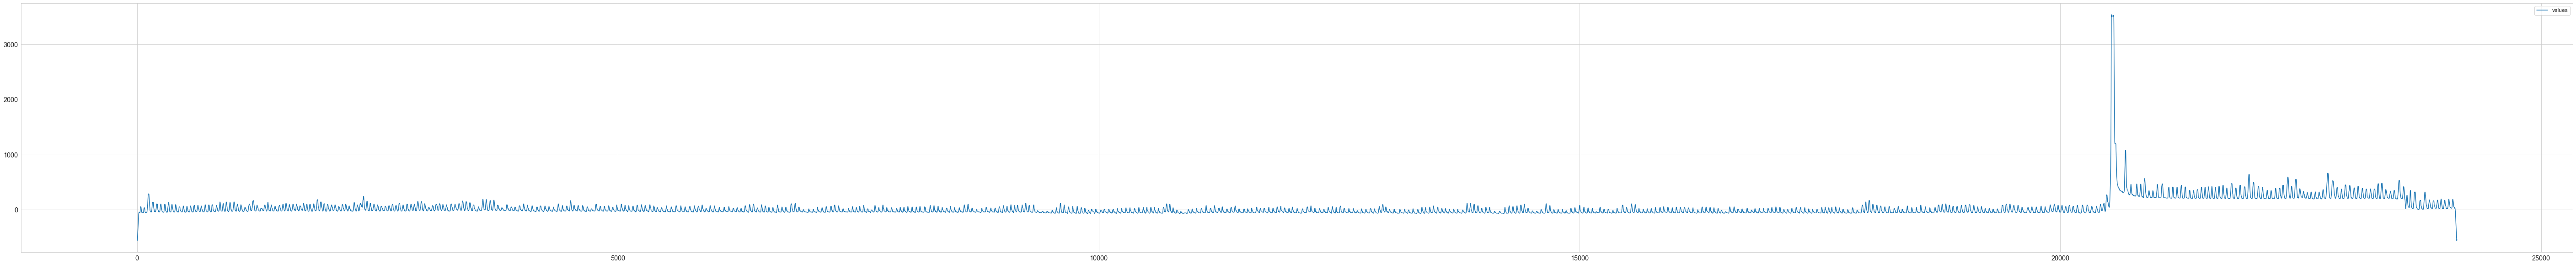

In [4]:
df.plot(figsize=(100,10))
plt.show()

values    11520
dtype: int64
<ipython-input-5-ae88970171e7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'] = 0


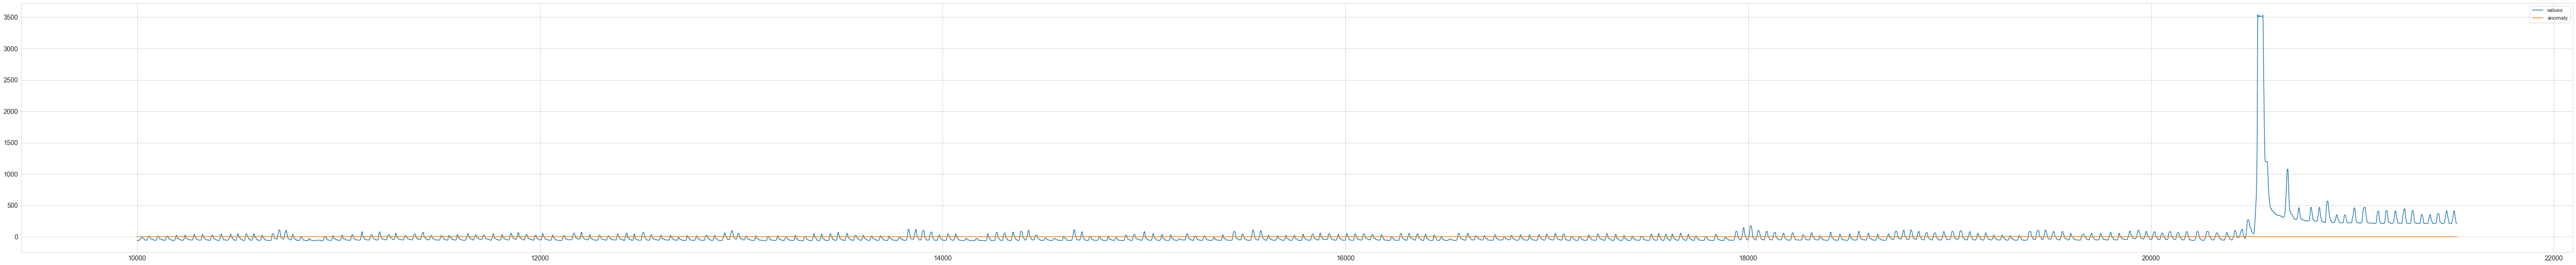

In [5]:
df = df[10000:21520]
print(df.count())

df['anomaly'] = 0

df.plot(figsize=(100,10))
plt.show()

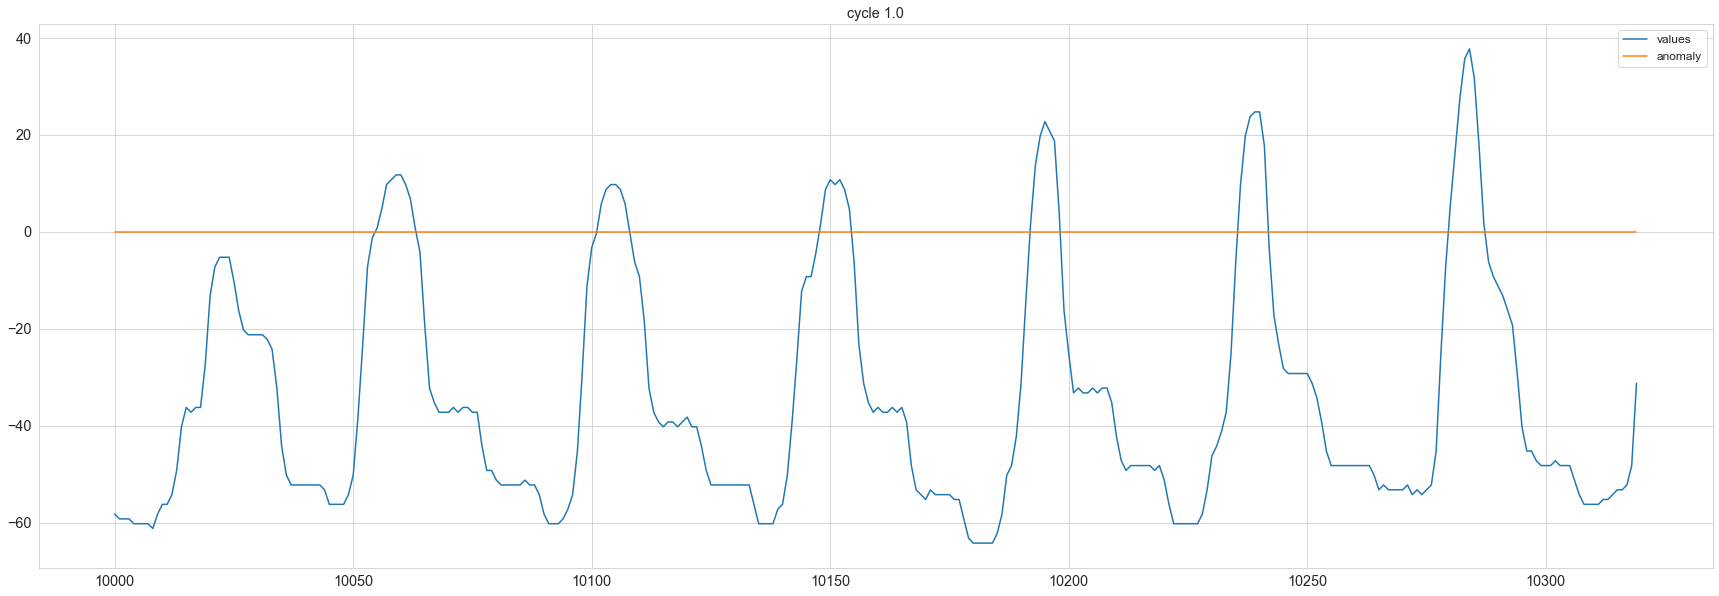

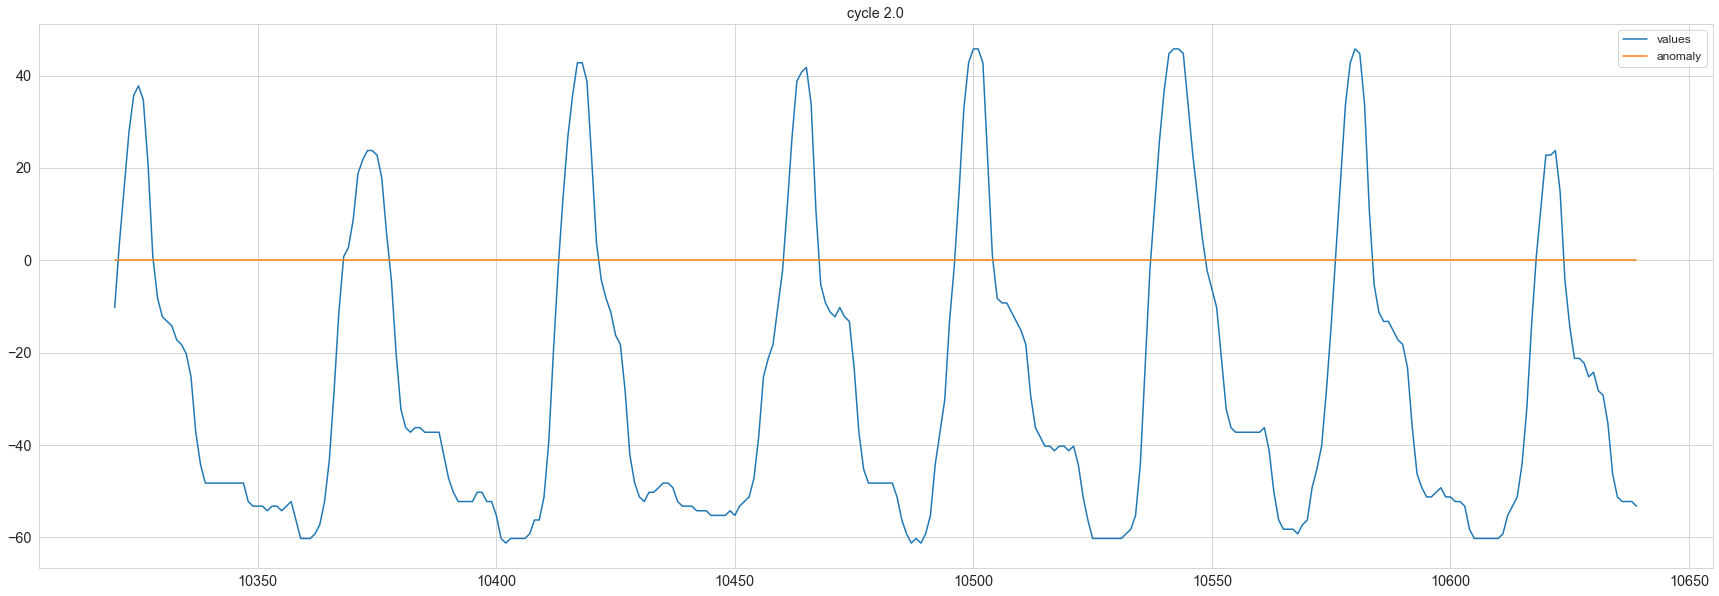

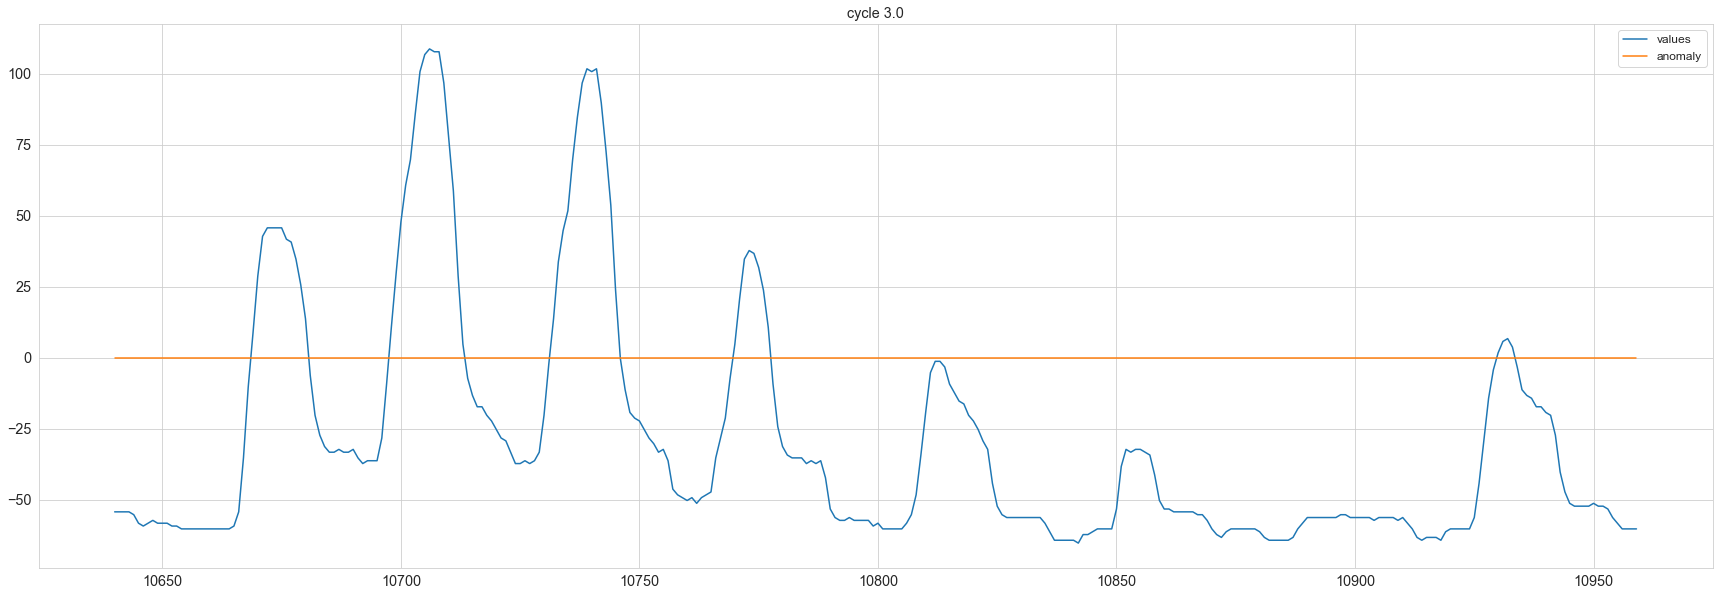

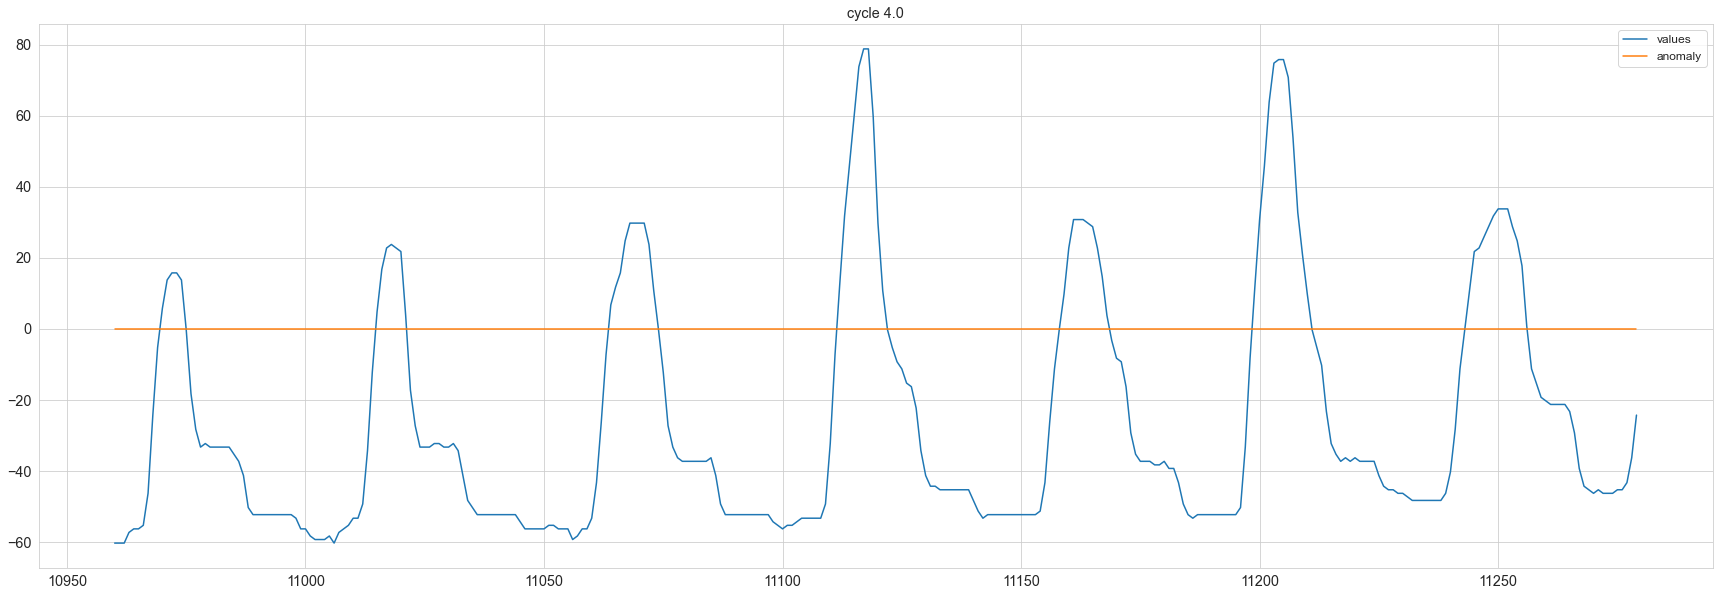

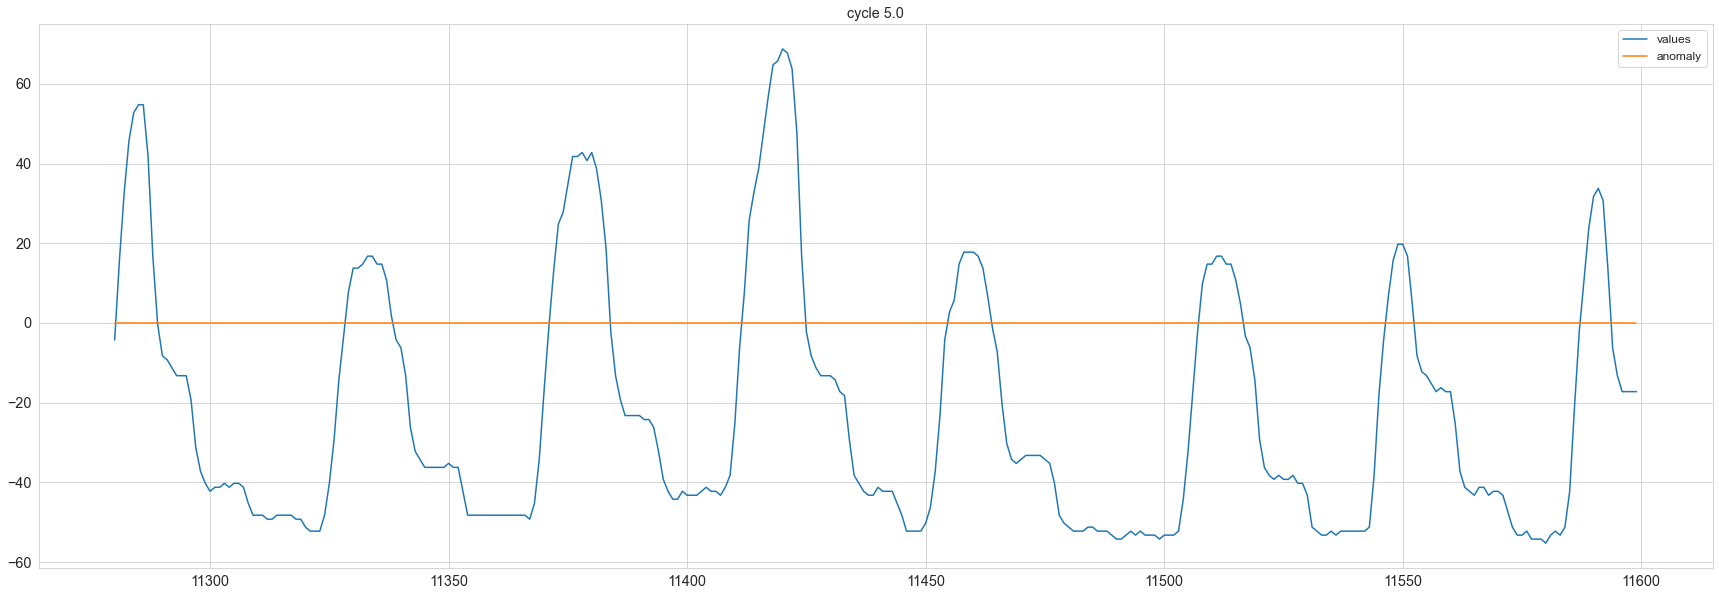

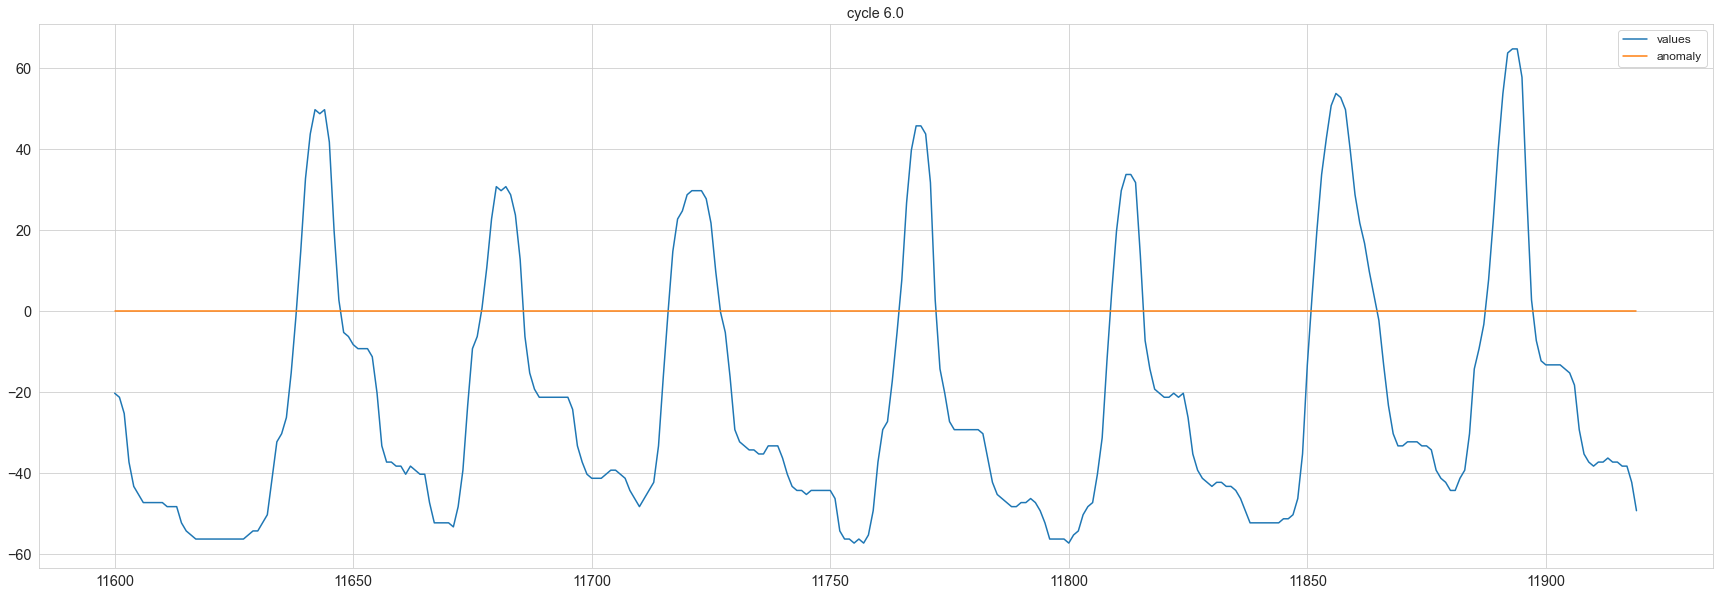

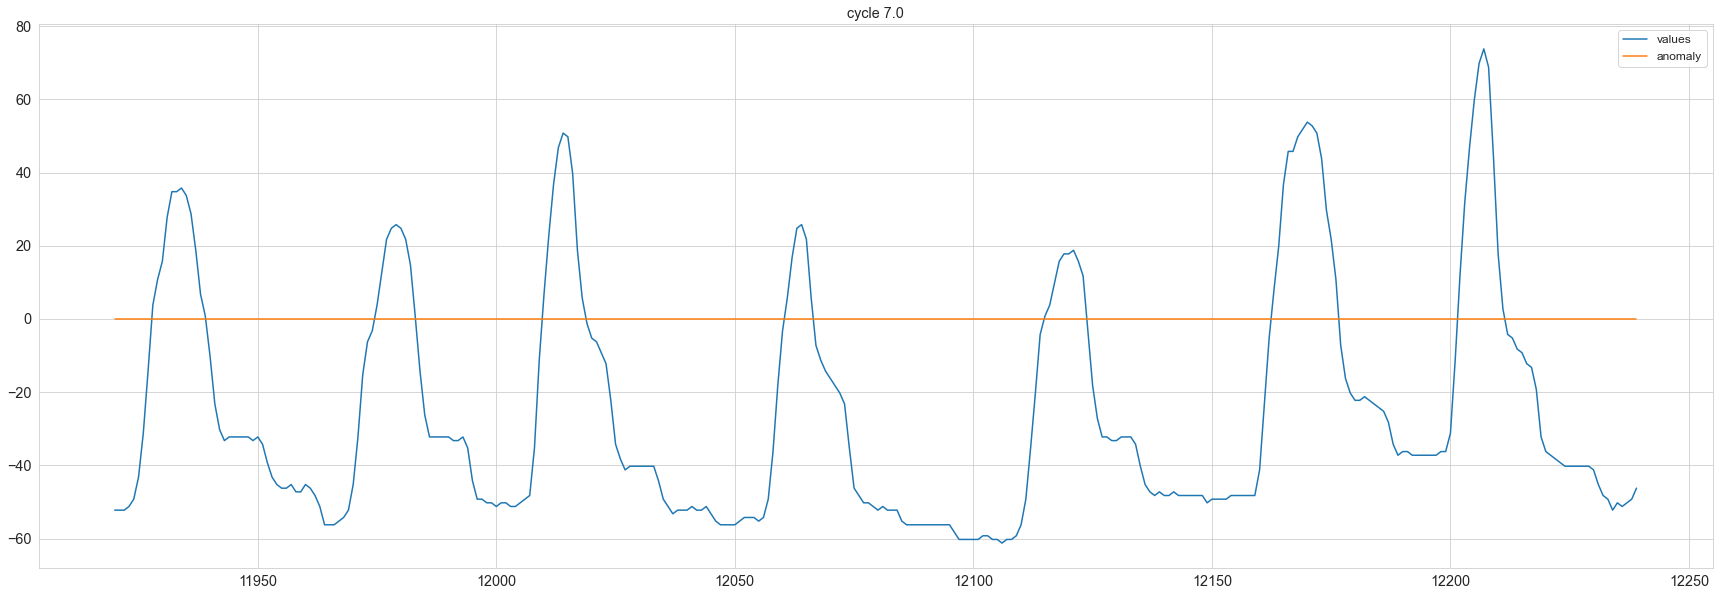

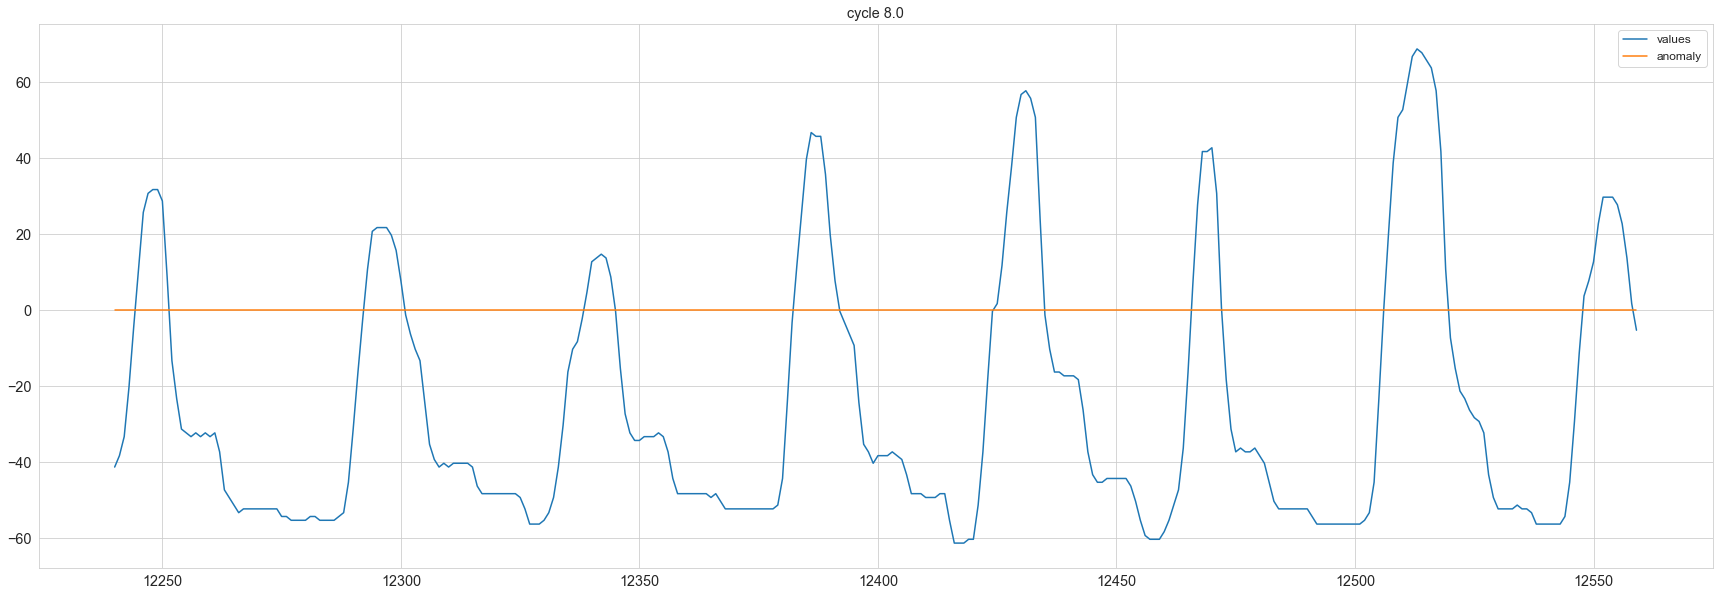

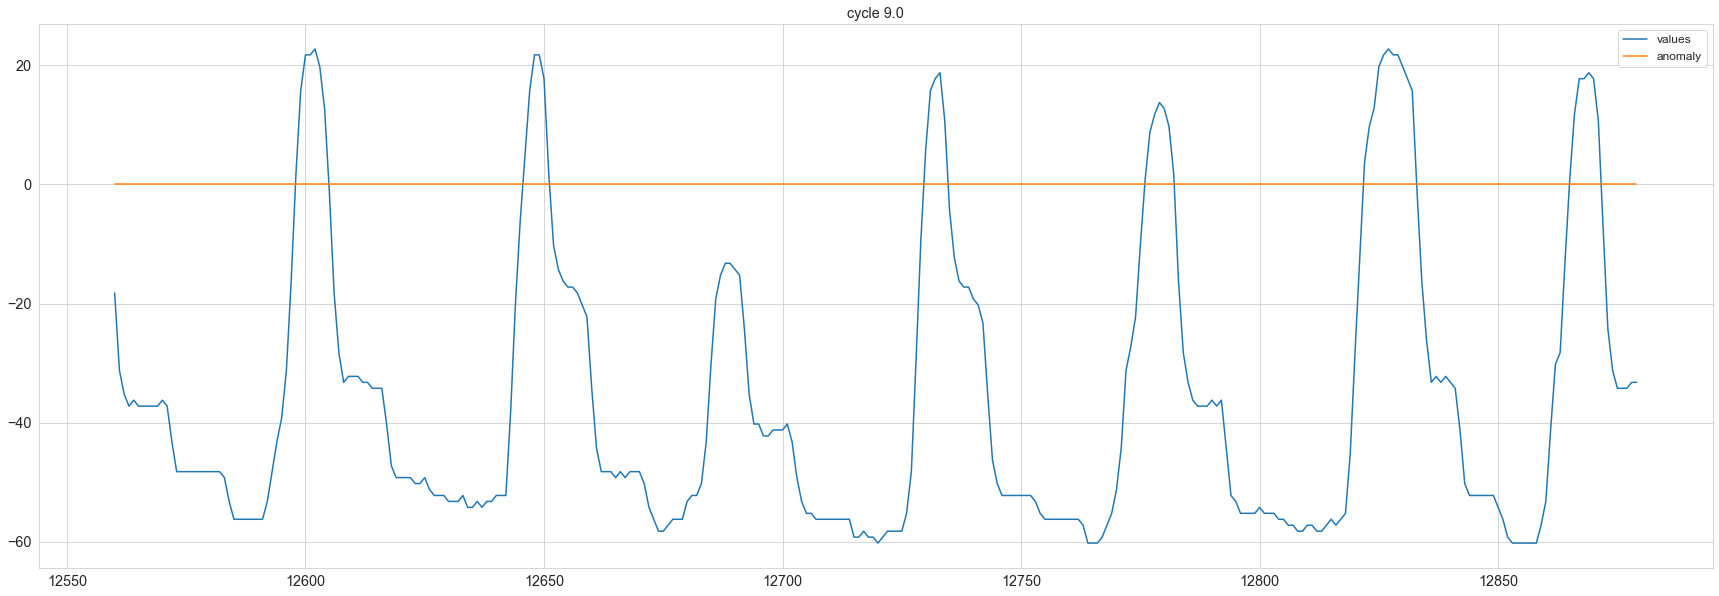

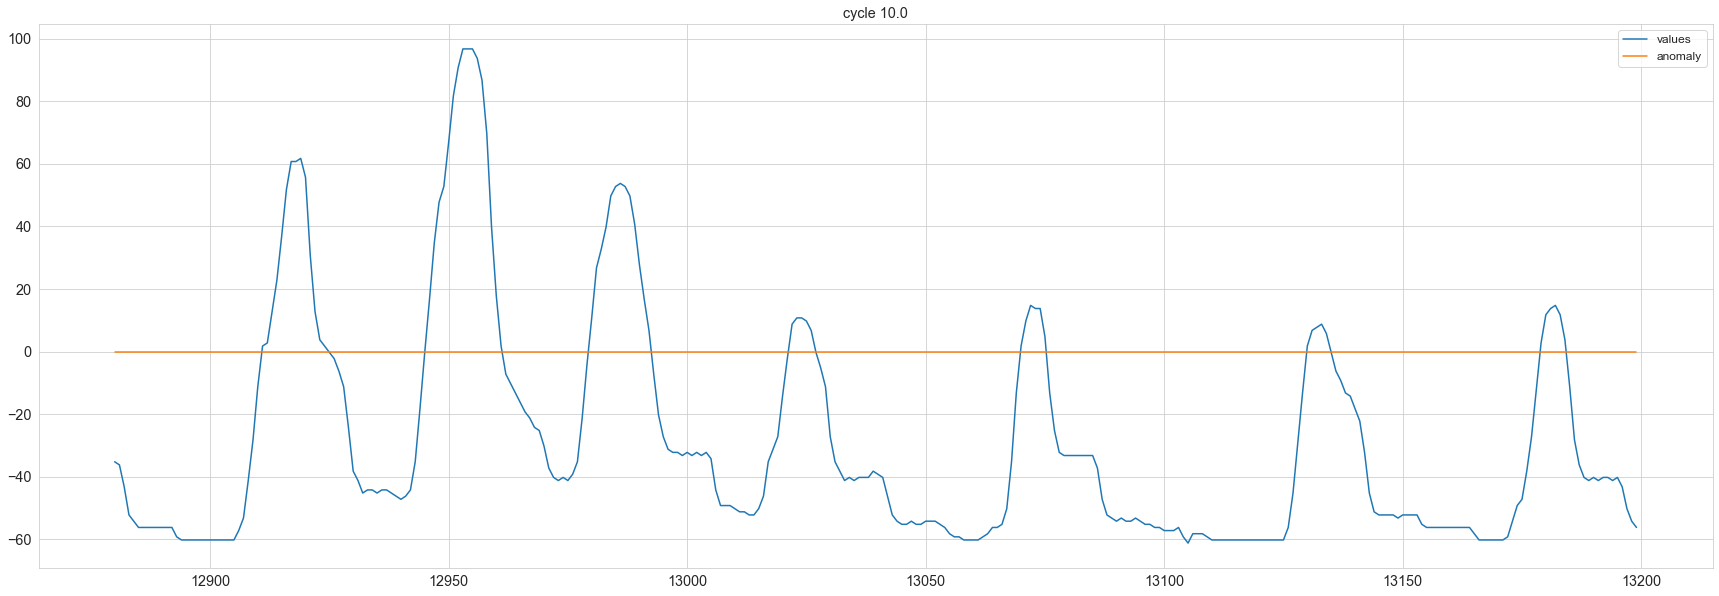

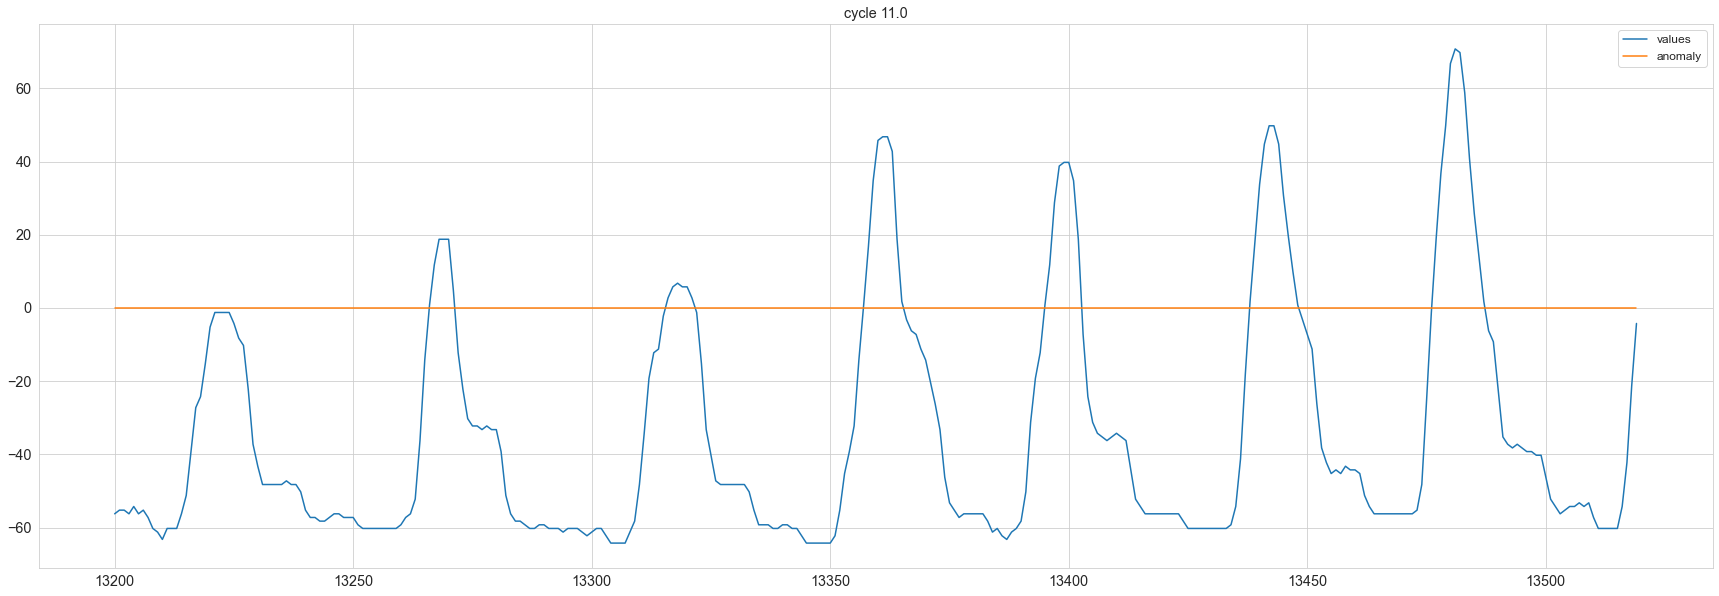

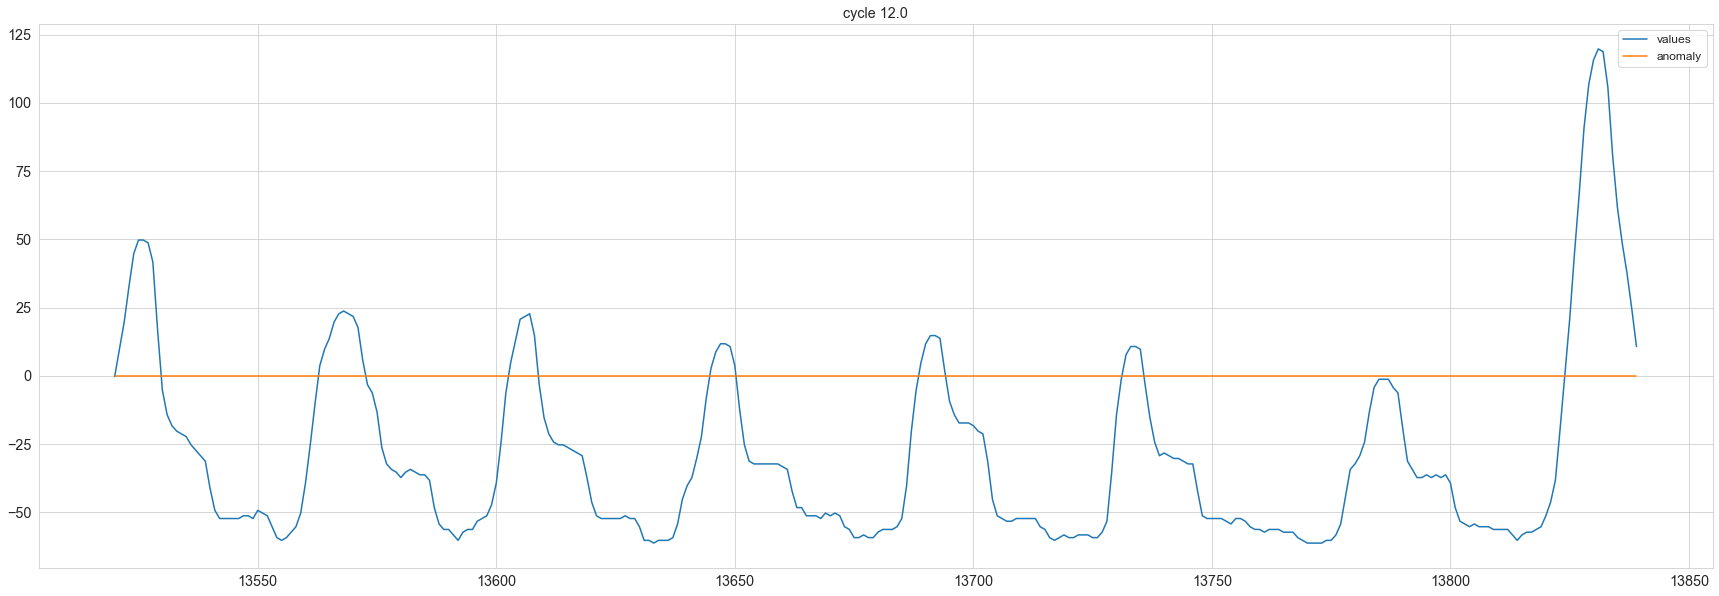

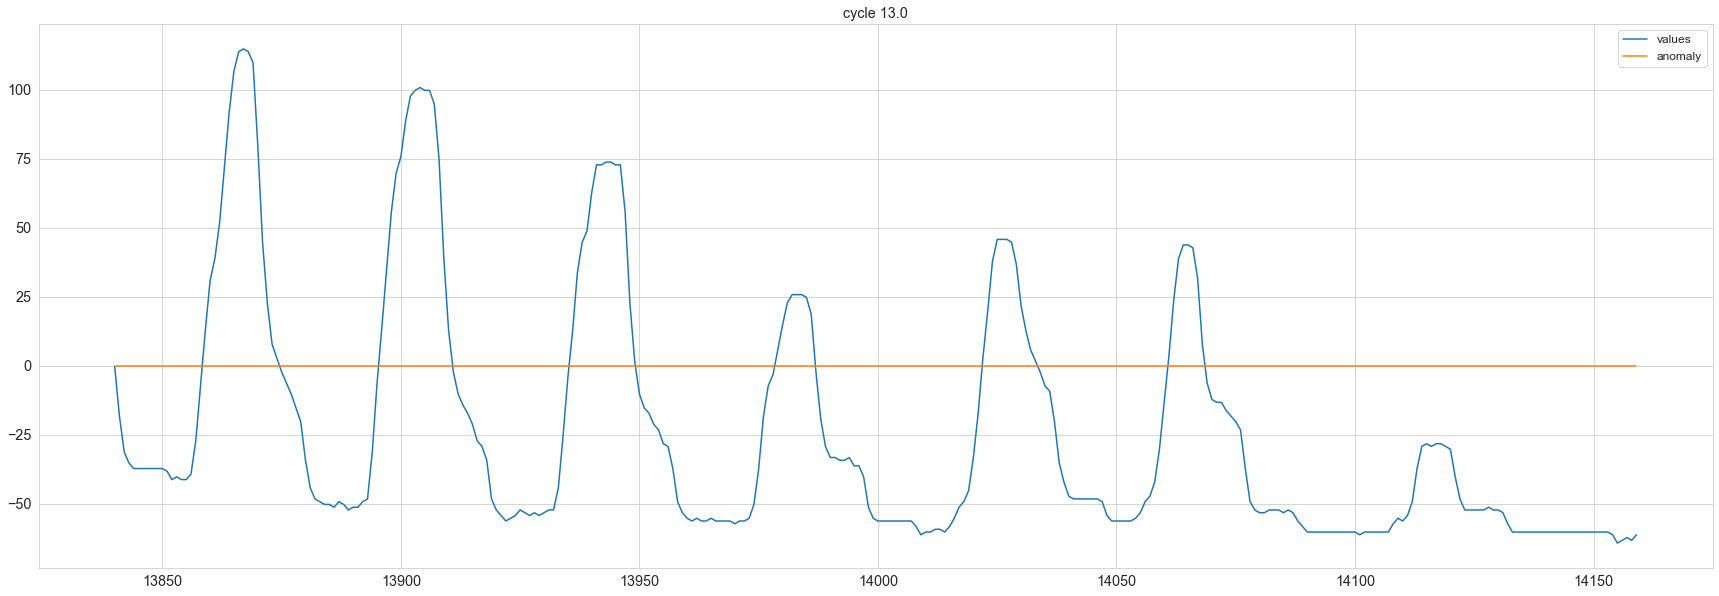

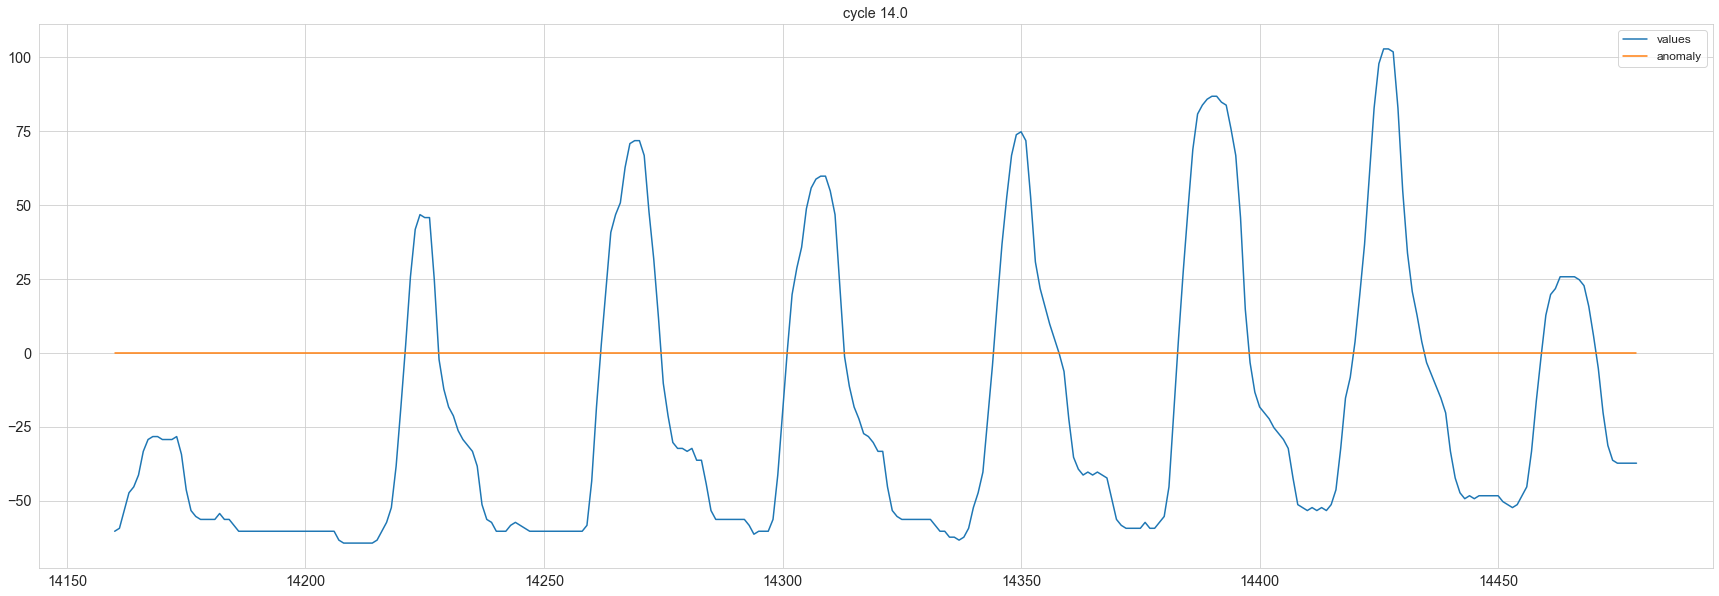

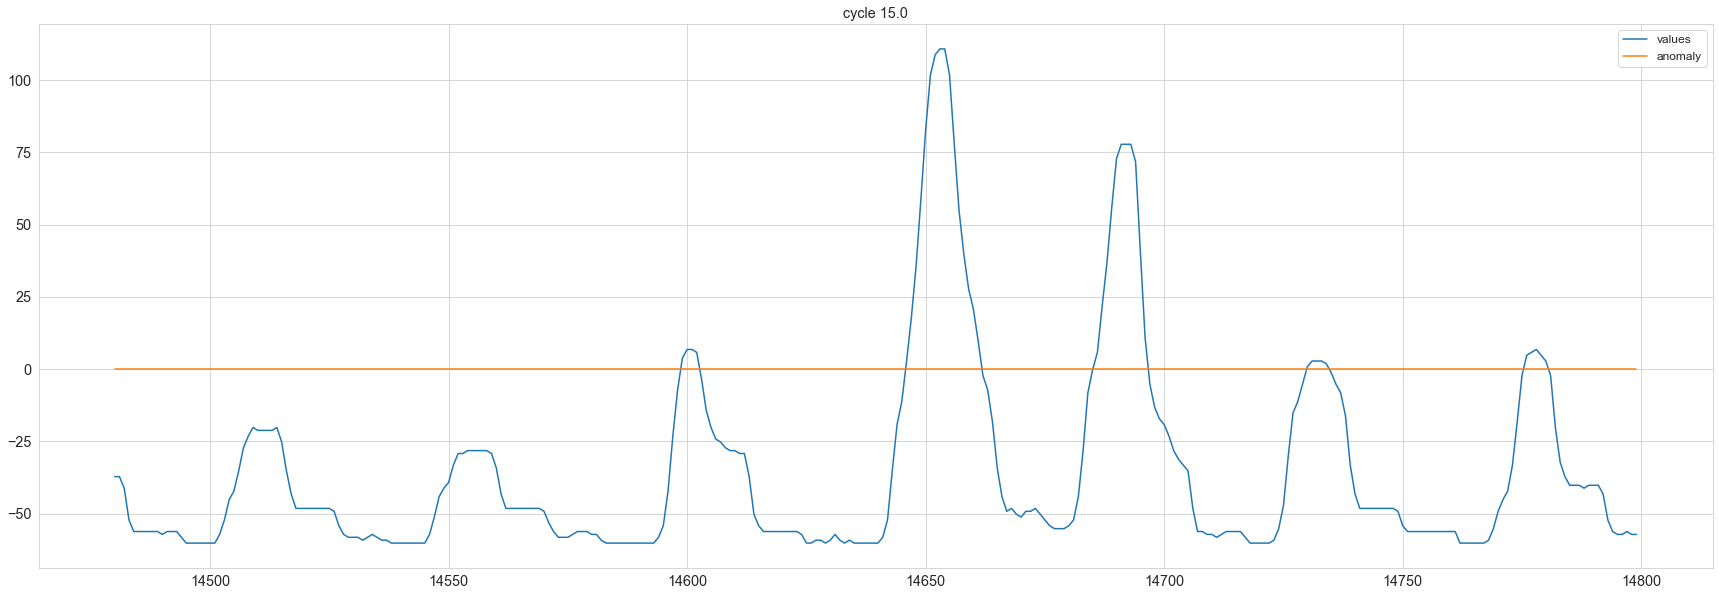

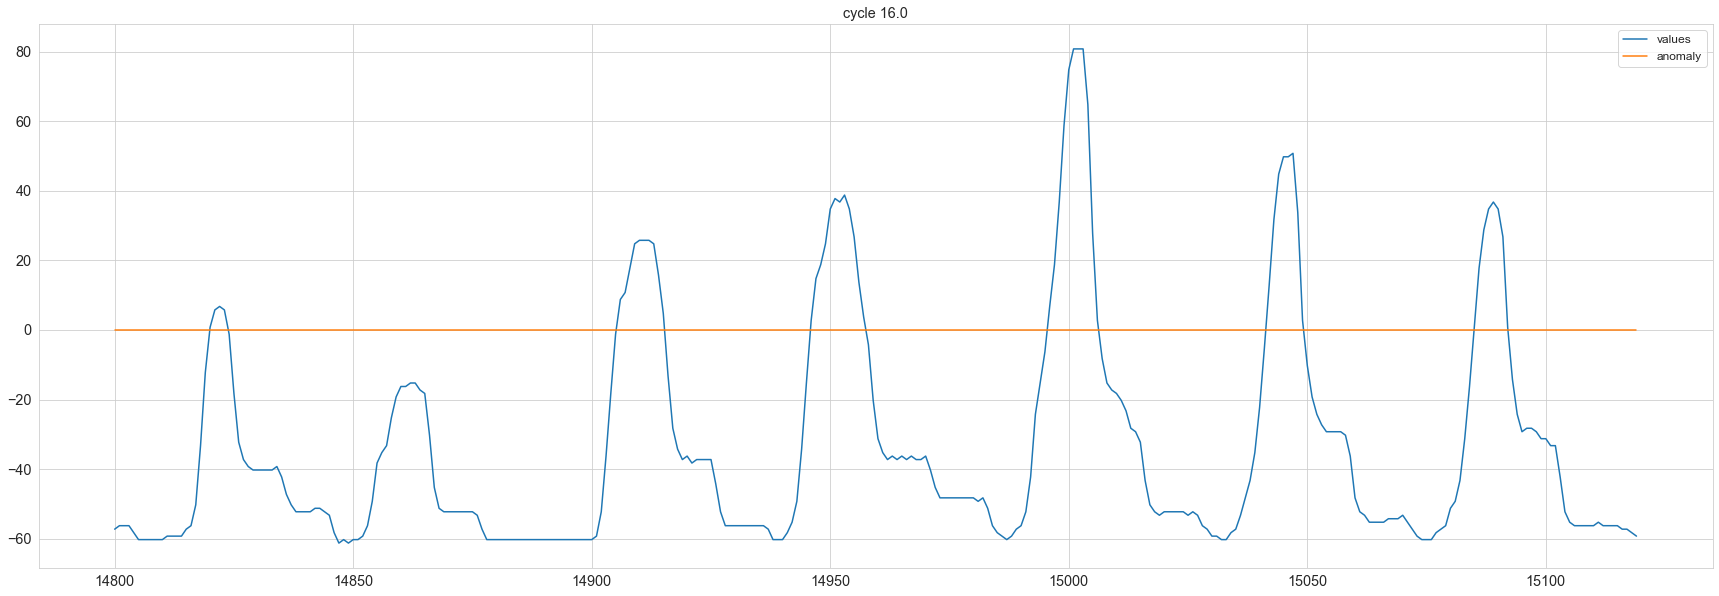

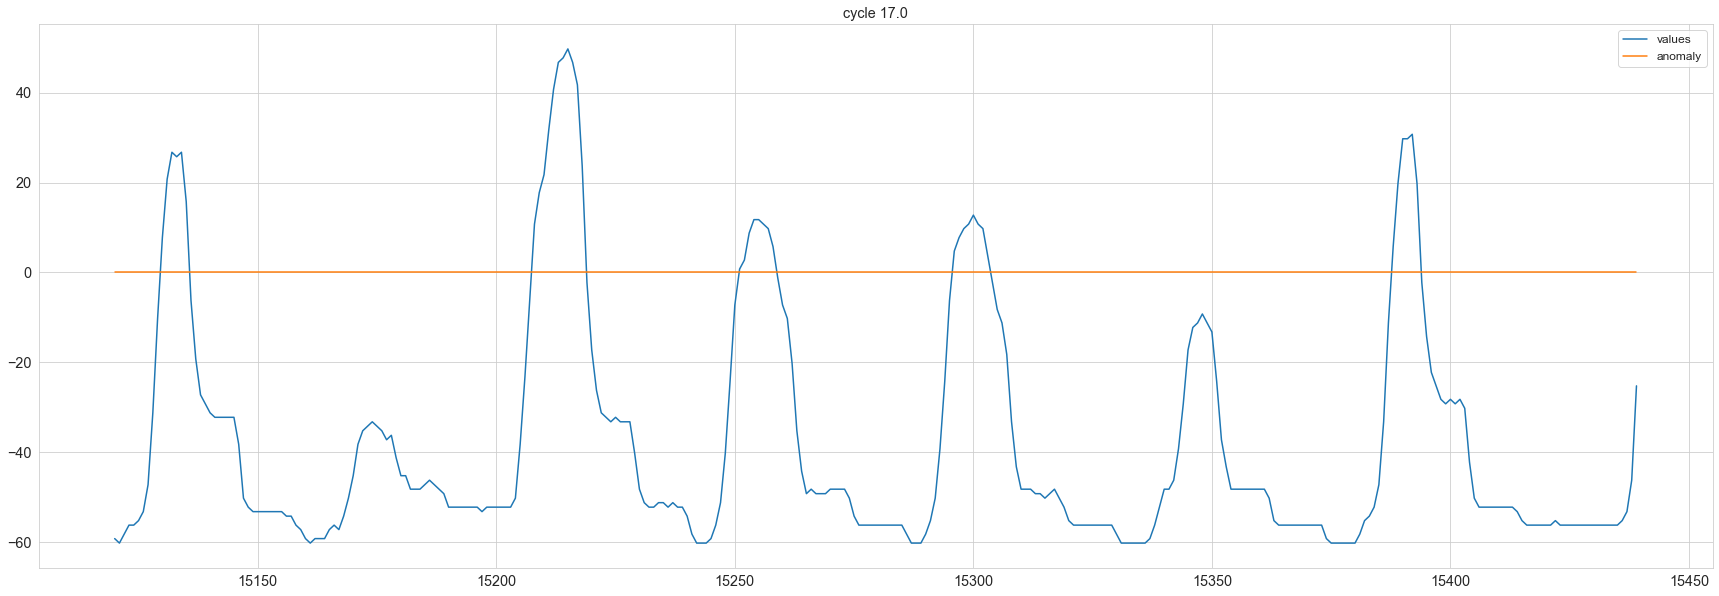

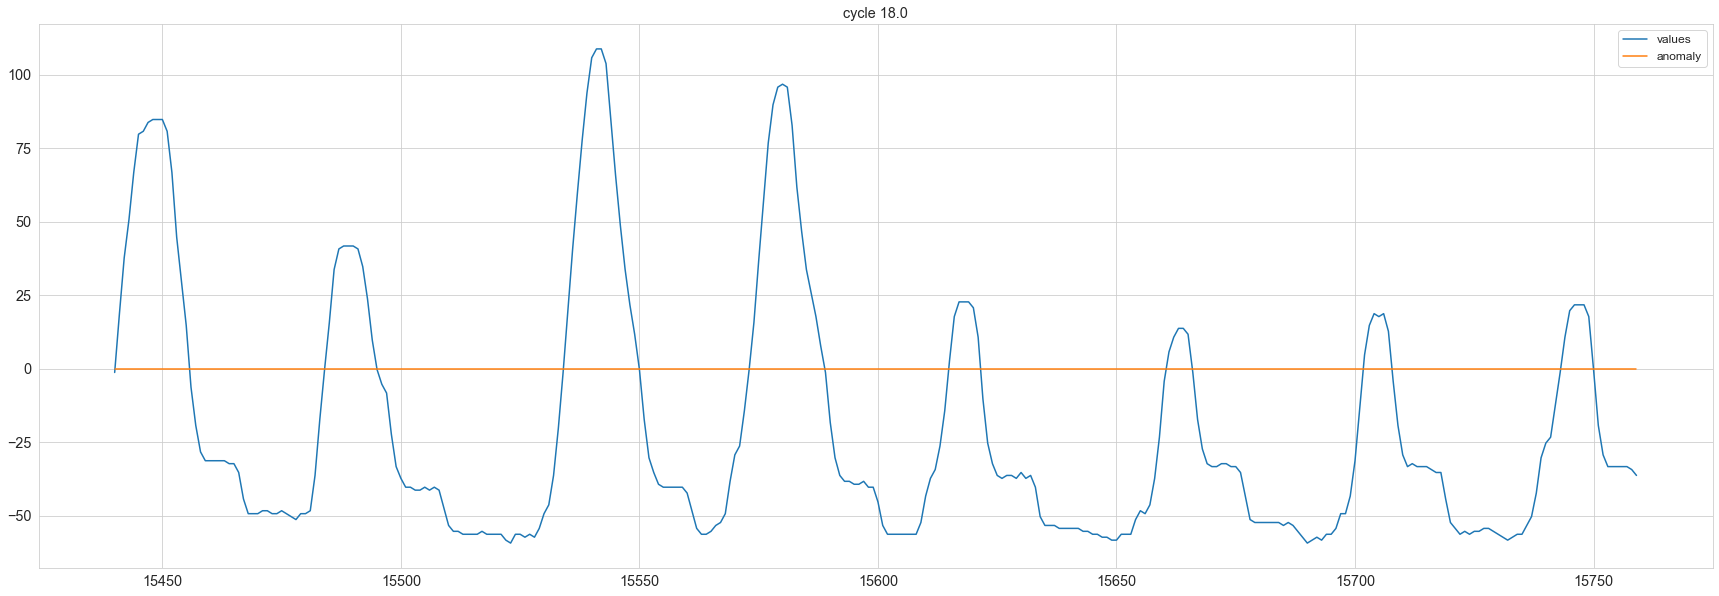

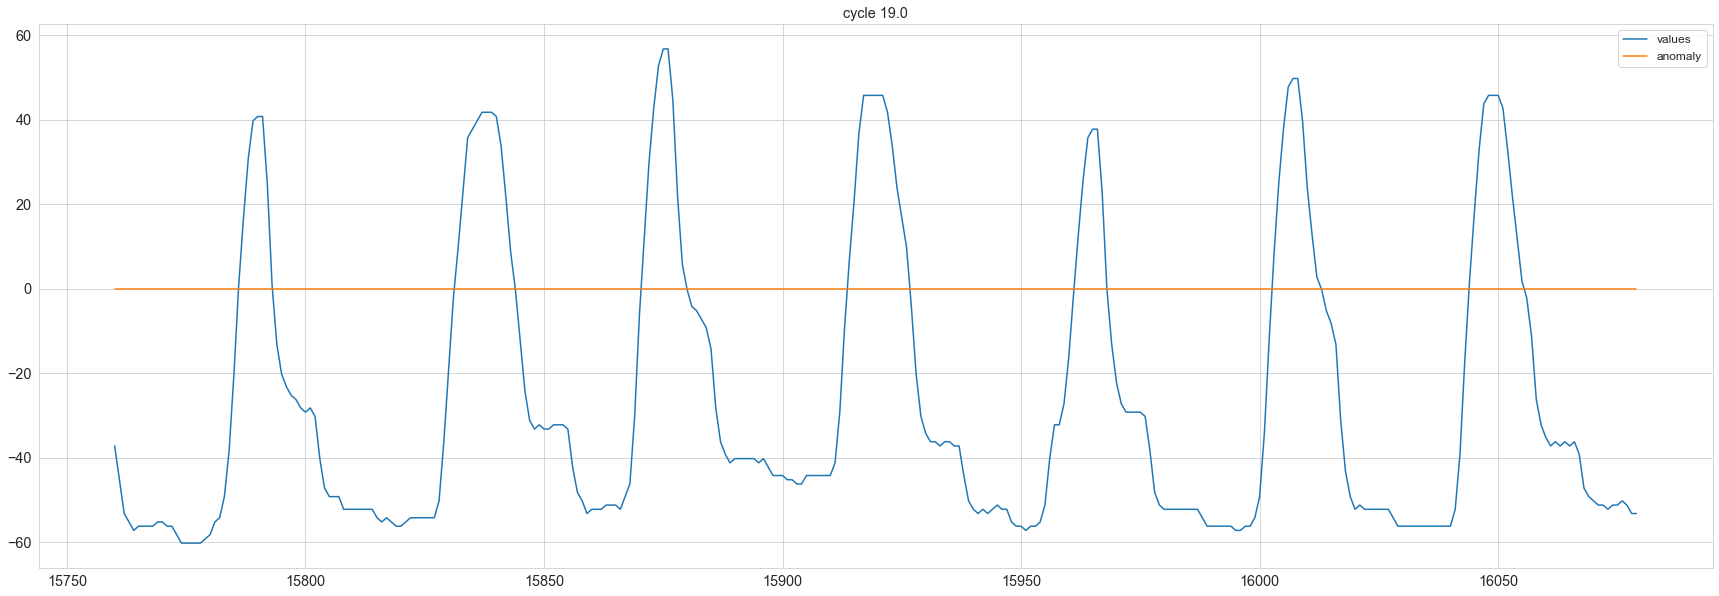

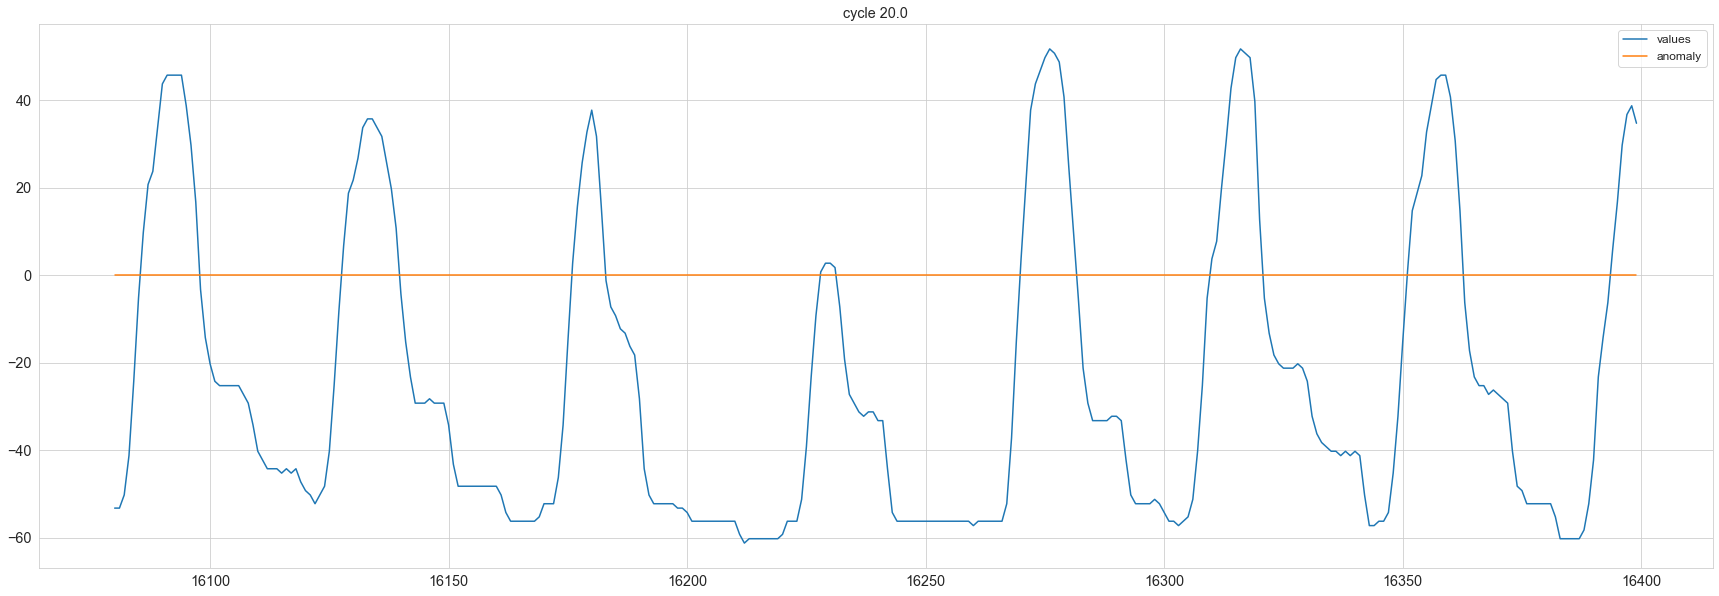

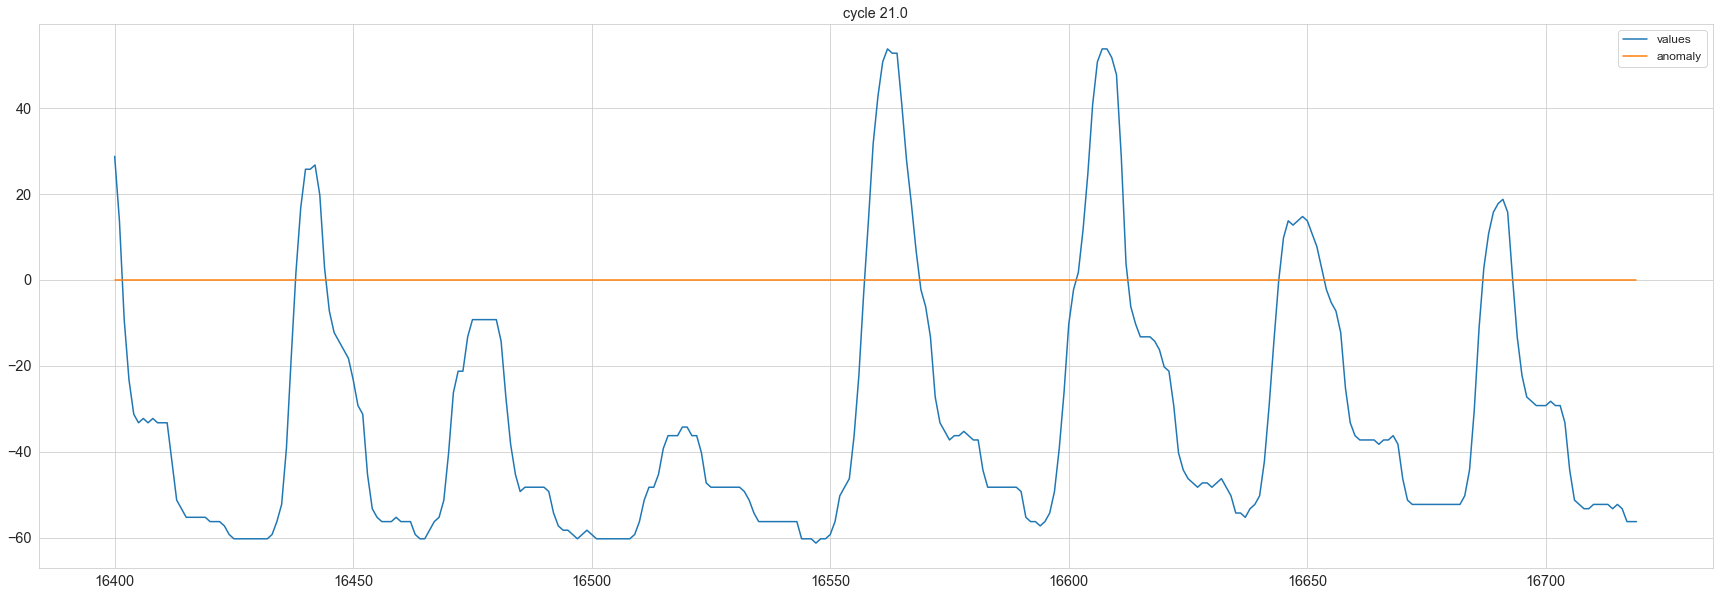

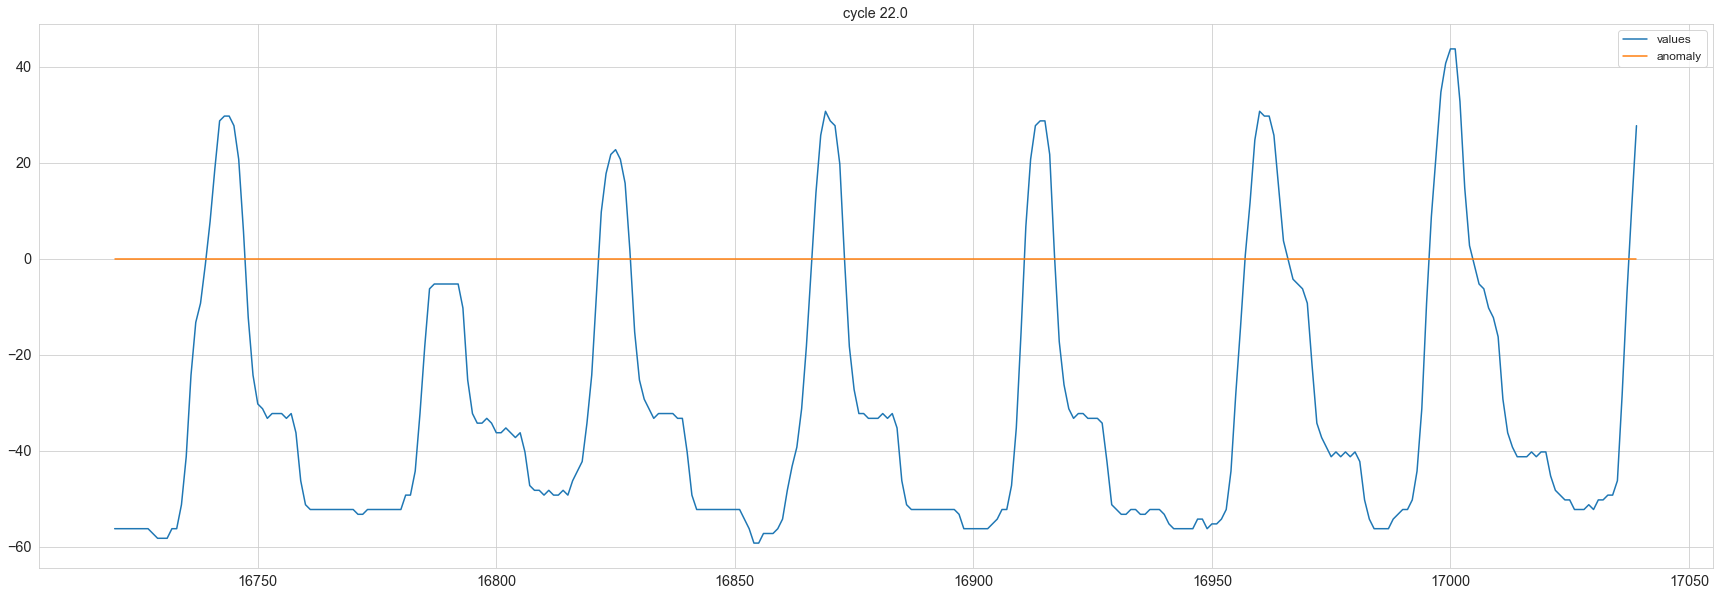

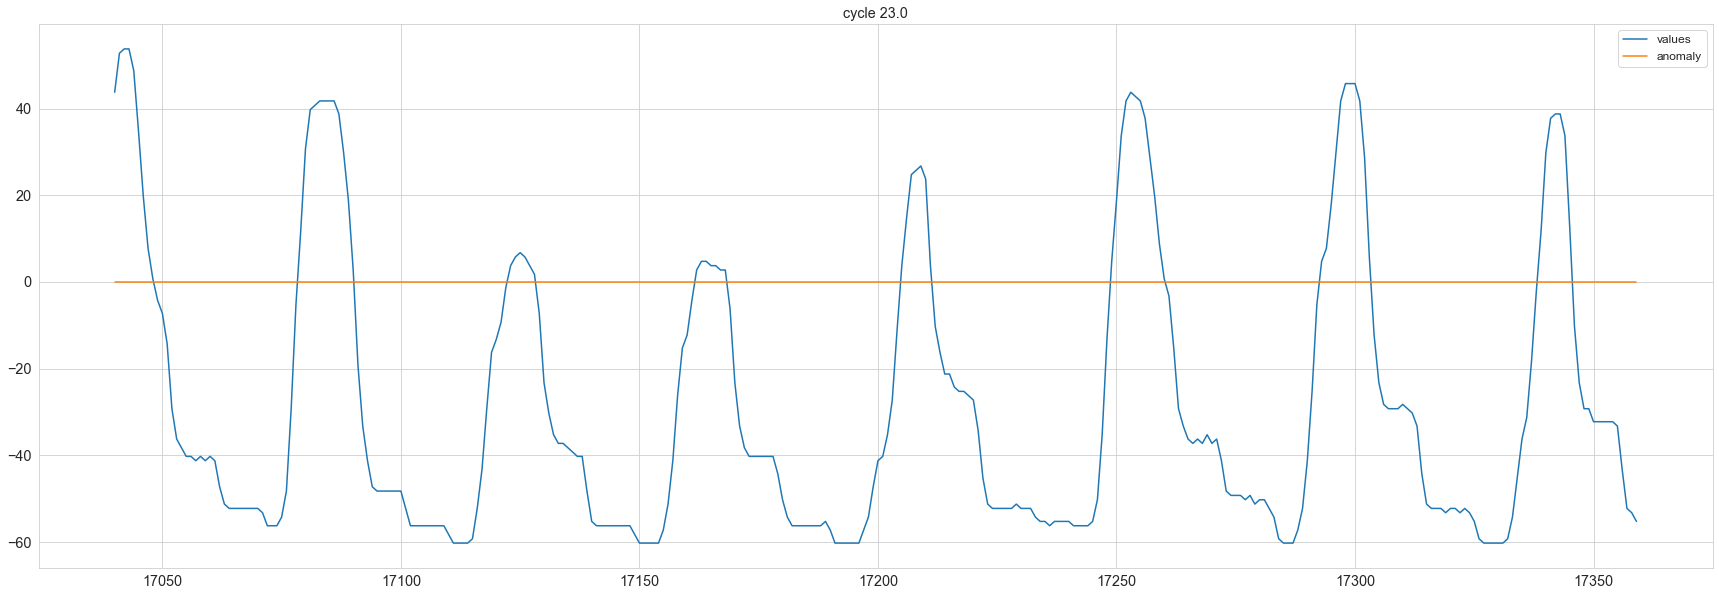

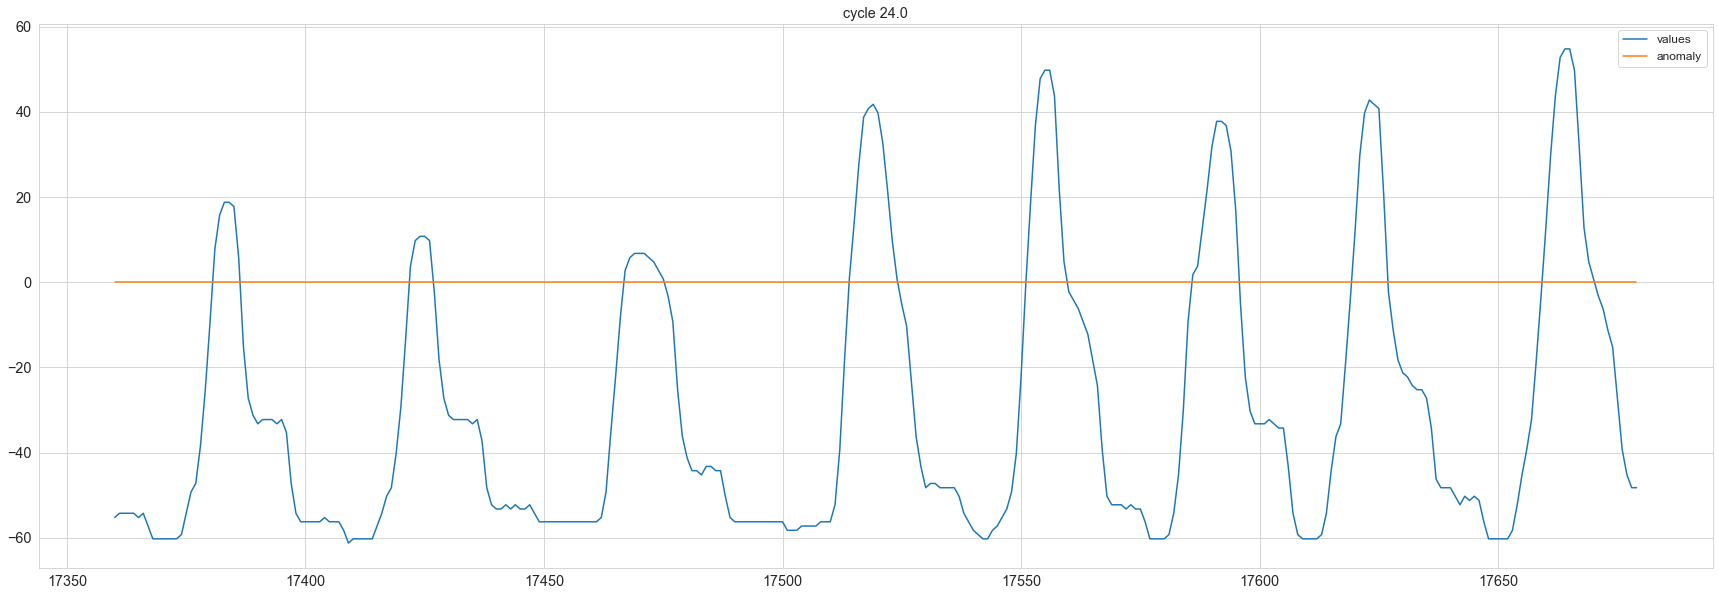

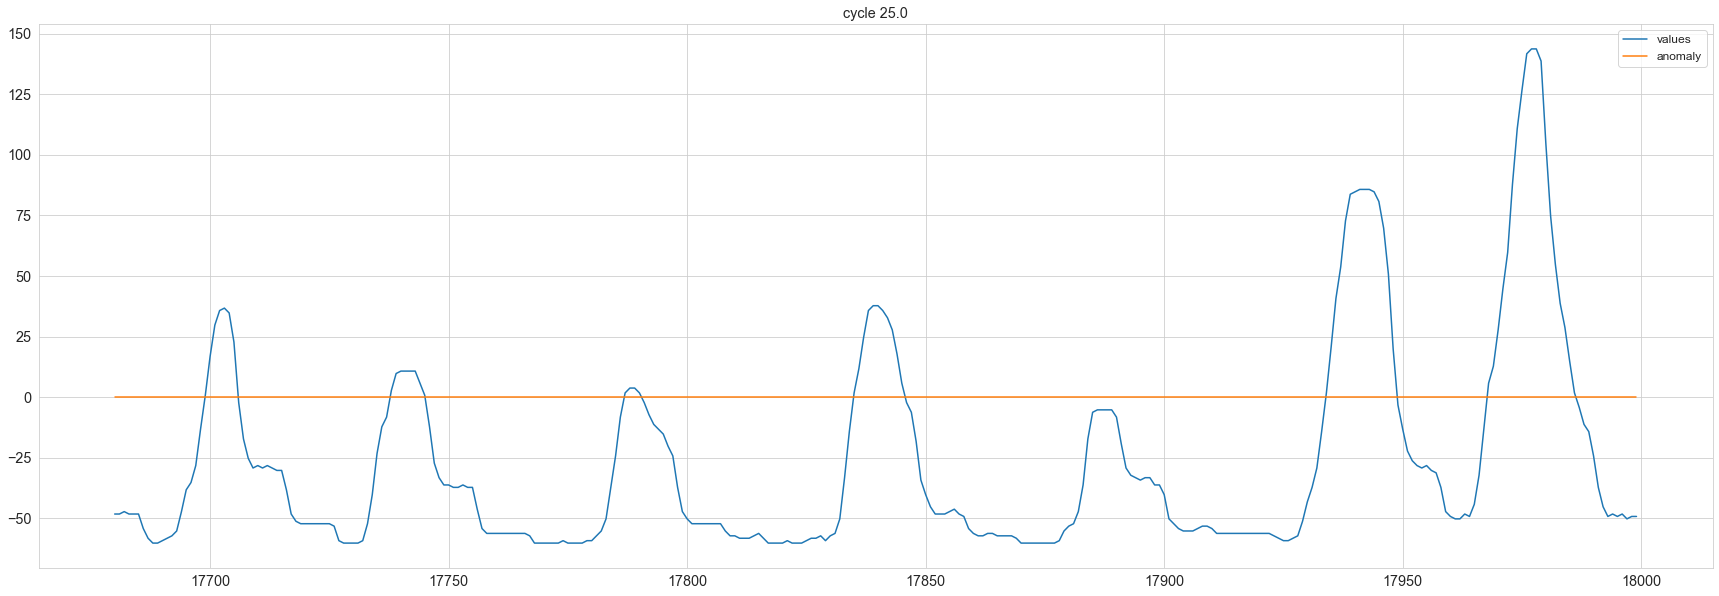

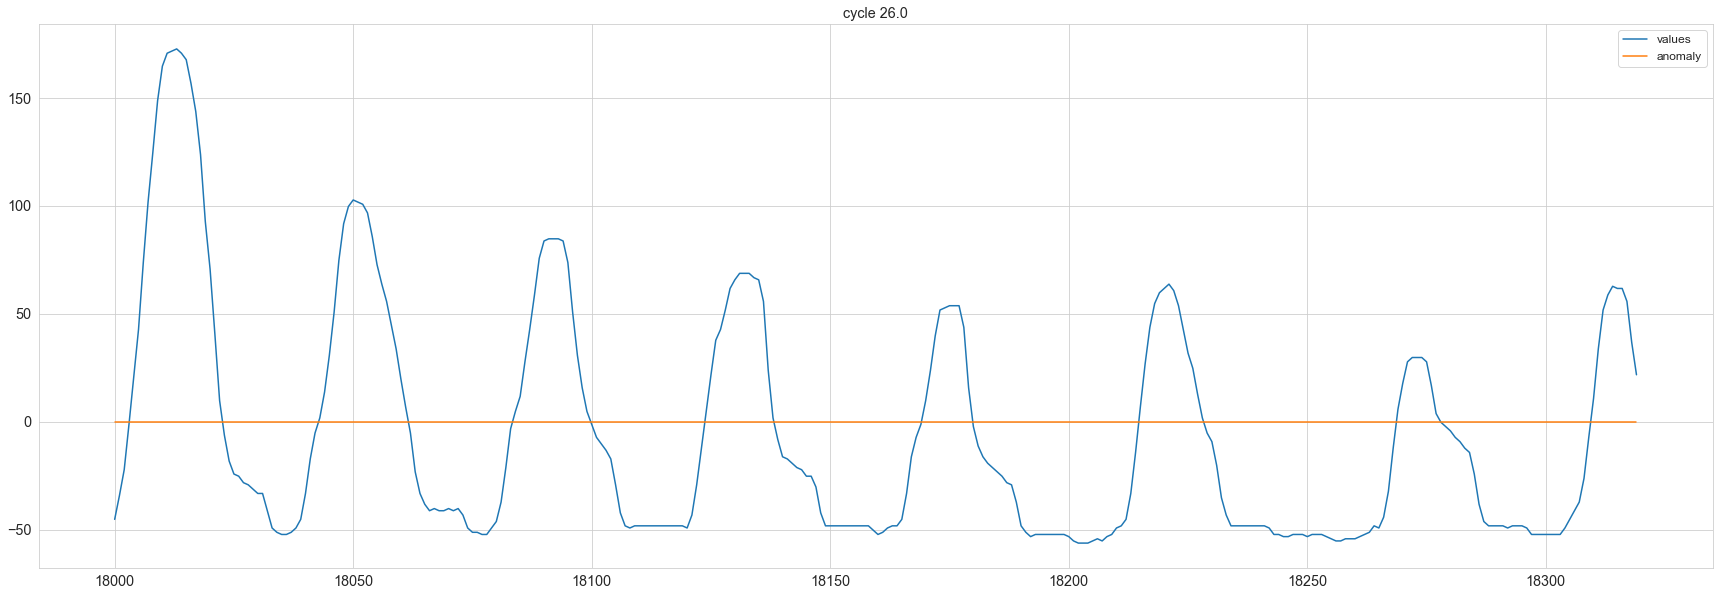

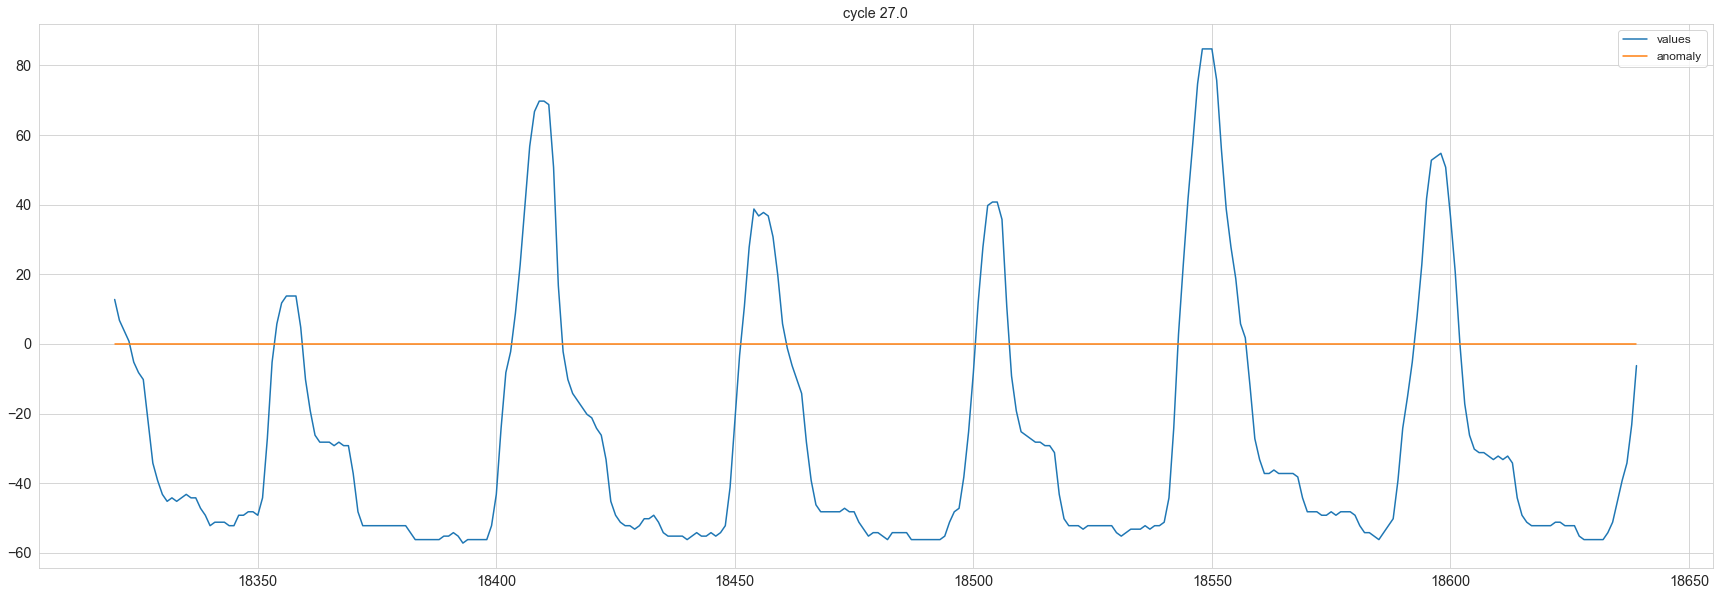

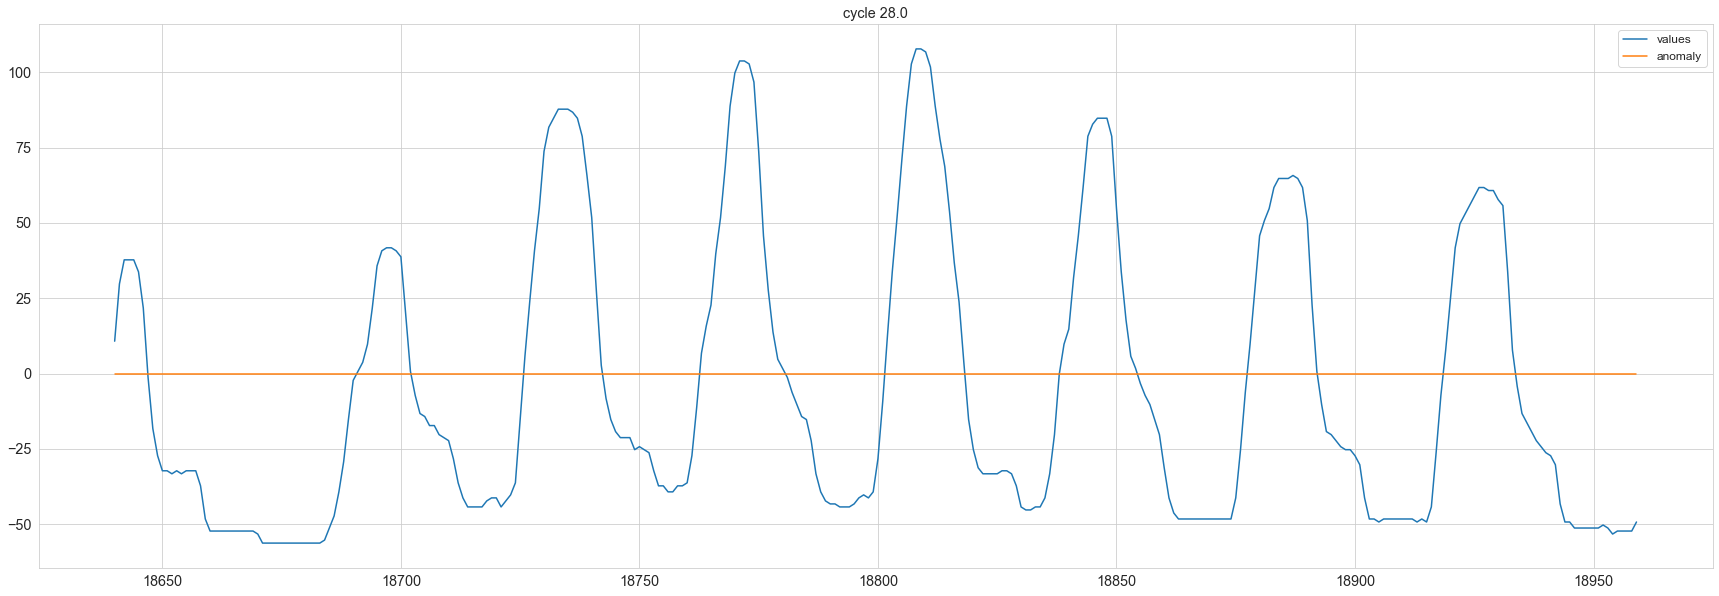

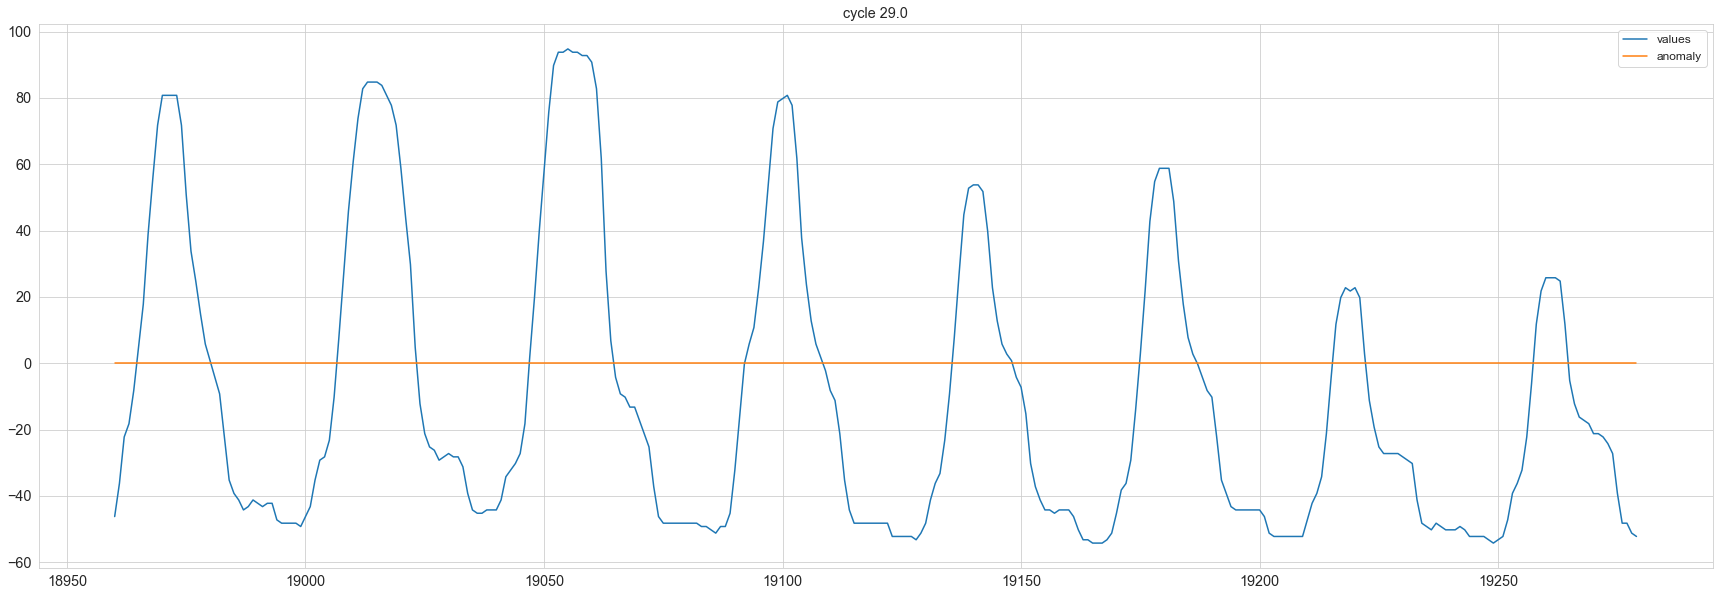

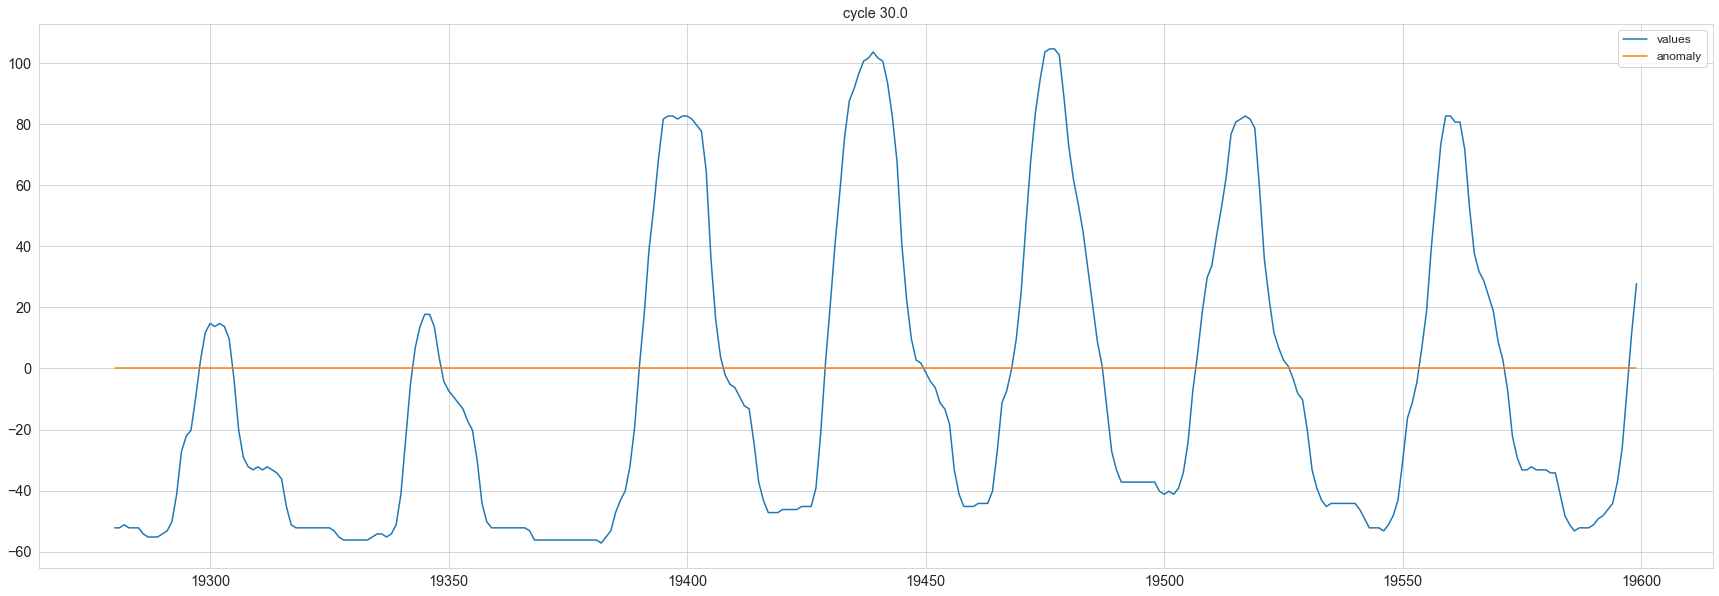

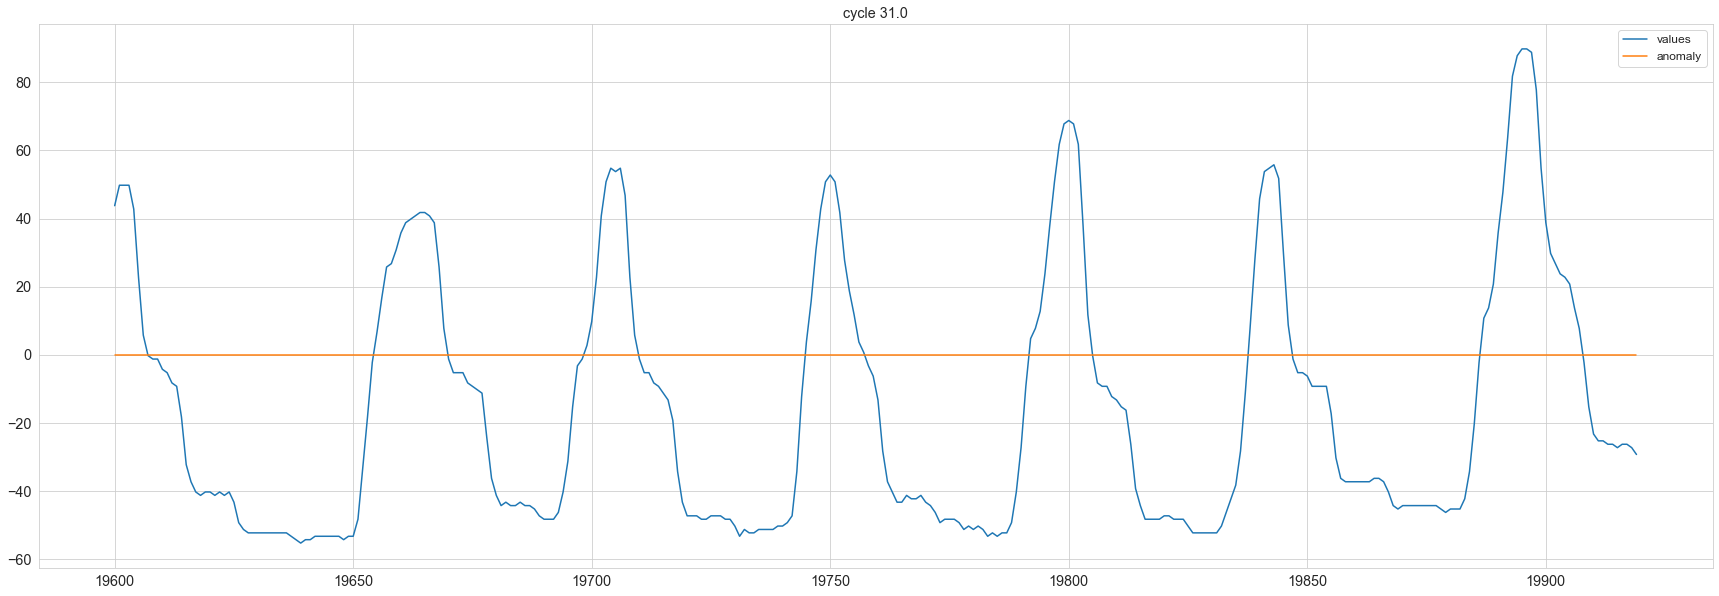

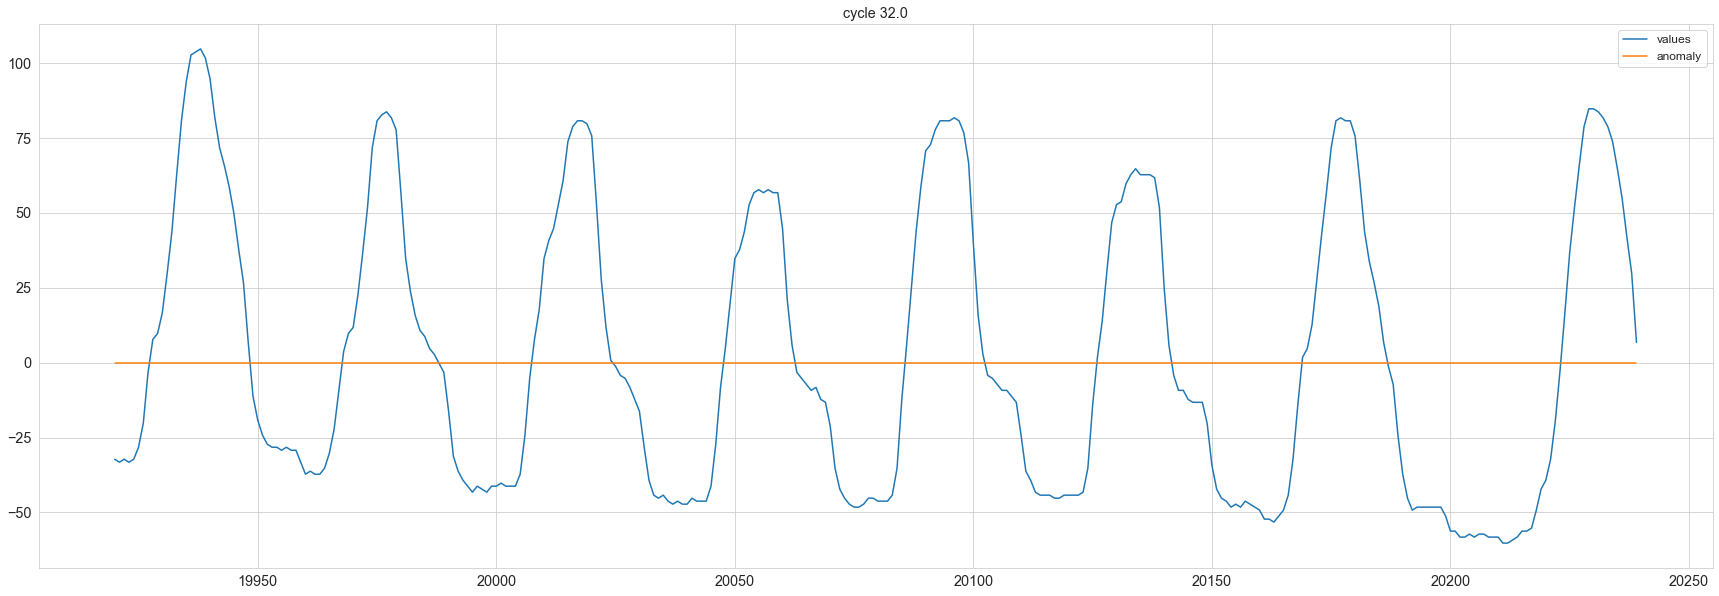

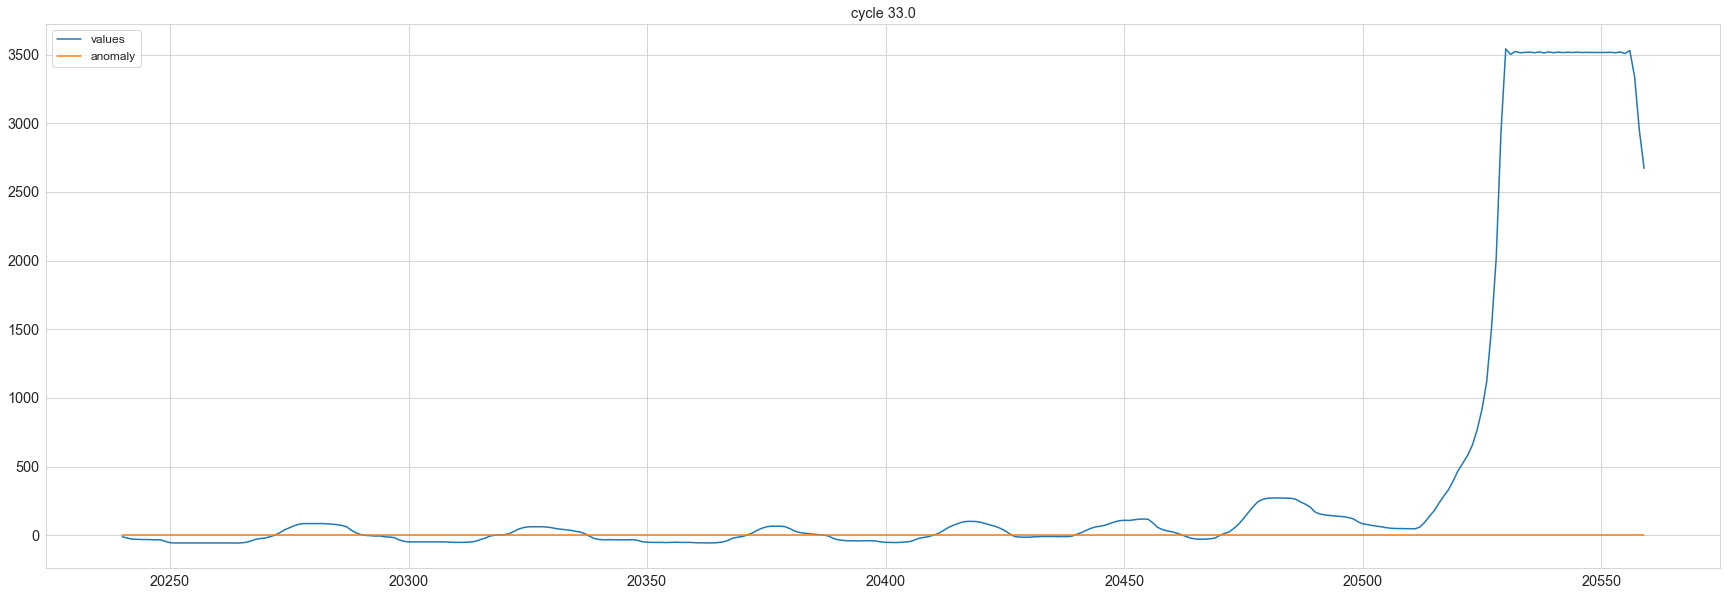

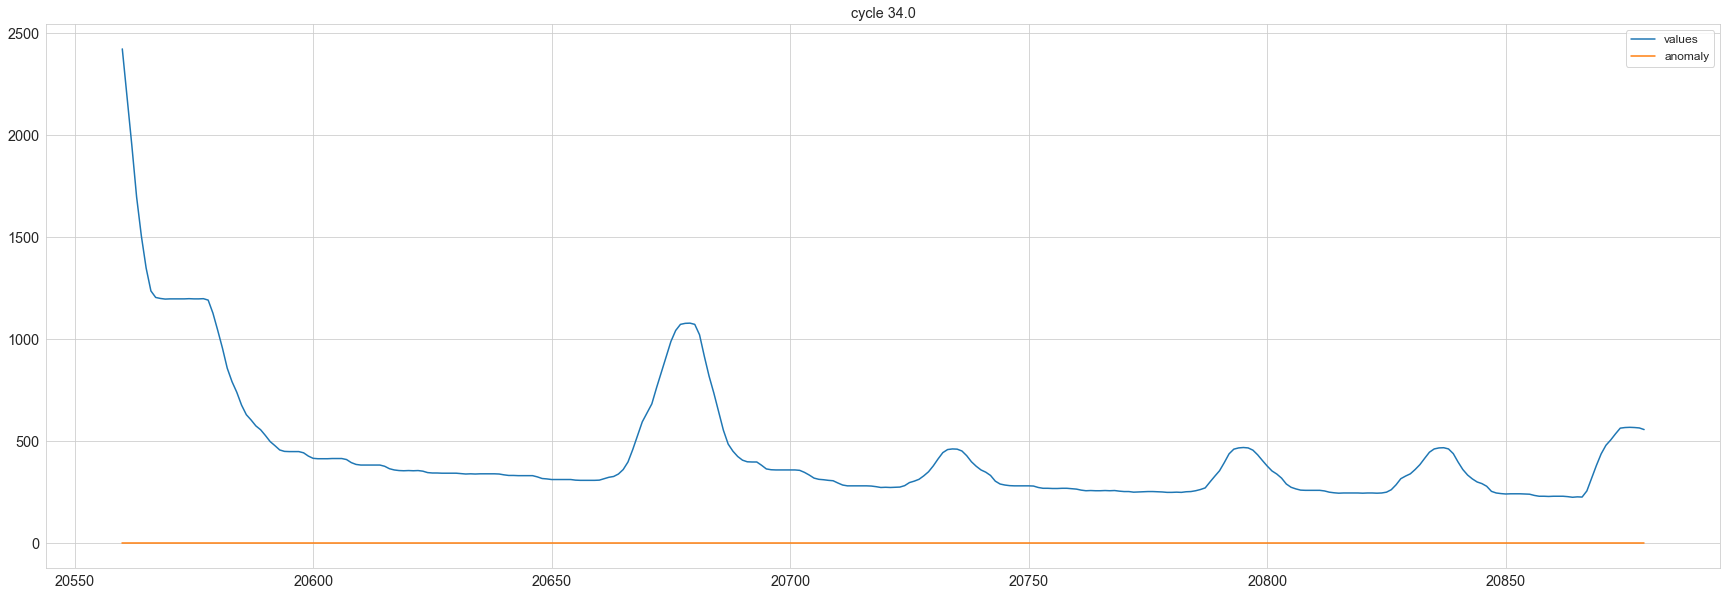

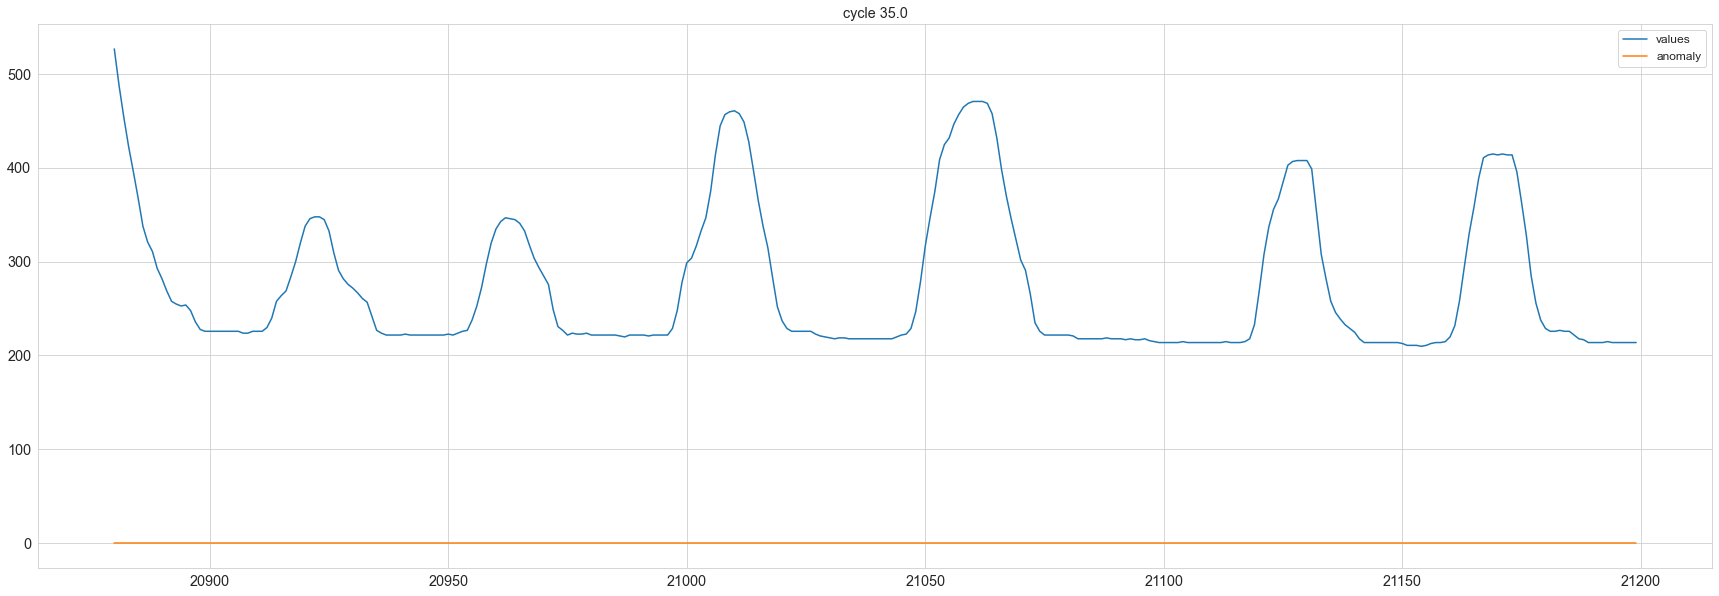

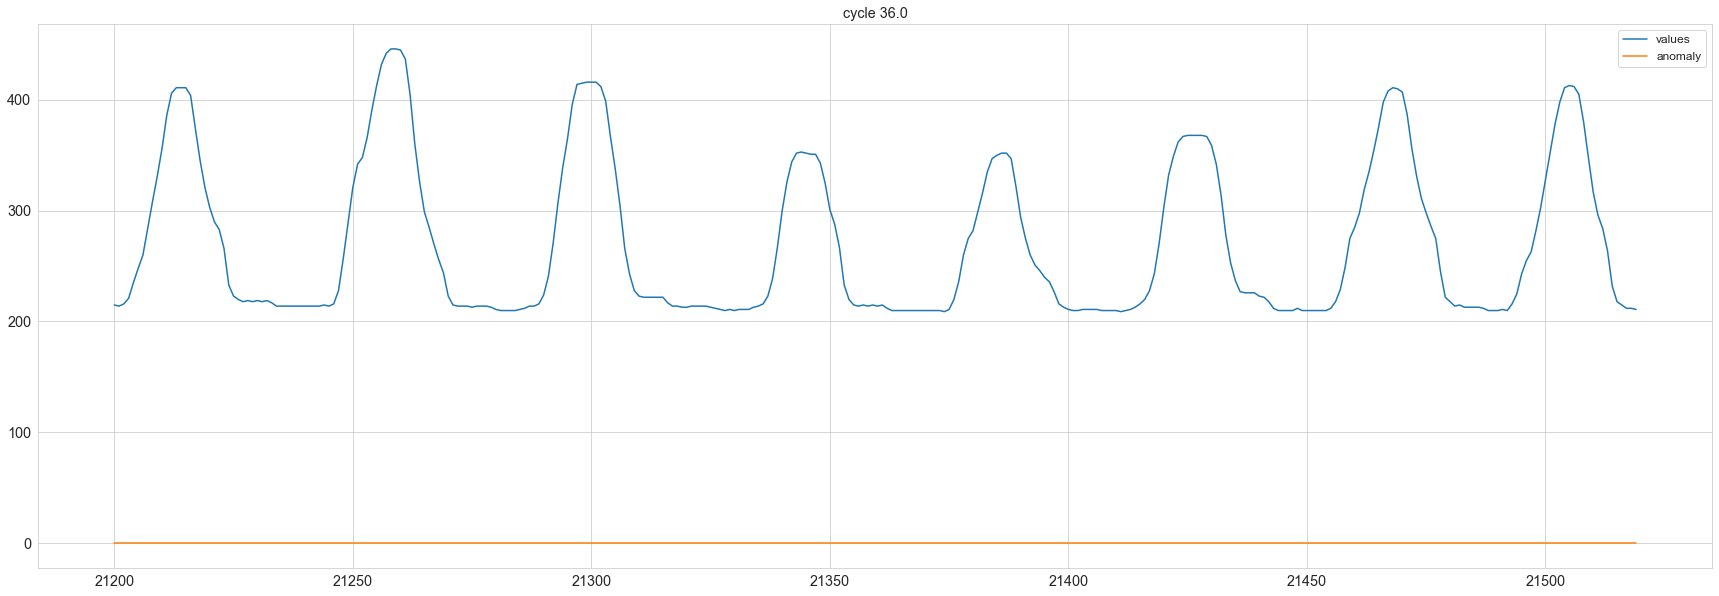

In [6]:
length = 32 #s
sample_per_second = 10 #f = 10Hz
step = length*sample_per_second
for i in range(0,df.shape[0],step):
    df[i:i+step].plot(figsize=(30,10))
    plt.title("cycle %s"%(i/step +1))
    plt.show()

In [7]:
length = 32 #s
sample_per_second = 10 #f = 10Hz
step = length*sample_per_second

anomaly_sample = [3,33,34,35]
validation1_sample = [7,8,9]
validation2_sample = [21,22,23,24]
test_sample = [30,31,32,33,34,35]
redundant_sample = [36]

df_train_list = []
df_valid1_list = []
df_valid2_list = []
df_test_list = []

for i in range(0,df.shape[0],step):
    sample = i/step +1

    if sample in validation1_sample:
        df_valid1_list.append(df[i:i+step])  
    elif sample in validation2_sample:
        if sample in anomaly_sample:
            df[i:i+step]['anomaly'] =1
        df_valid2_list.append(df[i:i+step])
    elif sample in test_sample:
        if sample in anomaly_sample:
            df[i:i+step]['anomaly'] =1
        df_test_list.append(df[i:i+step])
    else:
        if sample not in redundant_sample:
            df_train_list.append(df[i:i+step])
        

print(len(df_train_list))
print(len(df_valid1_list))
print(len(df_valid2_list))
print(len(df_test_list))

22
3
4
6
<ipython-input-7-9c8e8d0fdbf1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i:i+step]['anomaly'] =1


In [8]:
df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
df_validation1 = pd.concat(df_valid1_list)
df_validation2 = pd.concat(df_valid2_list)
df_dict = {}
df_dict['train'] = df_train
df_dict['test'] = df_test
df_dict['validation1'] = df_validation1
df_dict['validation2'] = df_validation2

In [9]:
df_dict['test'].head()

values  anomaly
19280 -52.235816        0
19281 -52.235816        0
19282 -51.235816        0
19283 -52.235816        0
19284 -52.235816        0

Size of train: (7040, 2)
Size of test: (1920, 2)
Size of validation1: (960, 2)
Size of validation2: (1280, 2)
Total: 11200
Ratio of train: 0.628571
Ratio of test: 0.171429
Ratio of validation1: 0.085714
Ratio of validation2: 0.114286


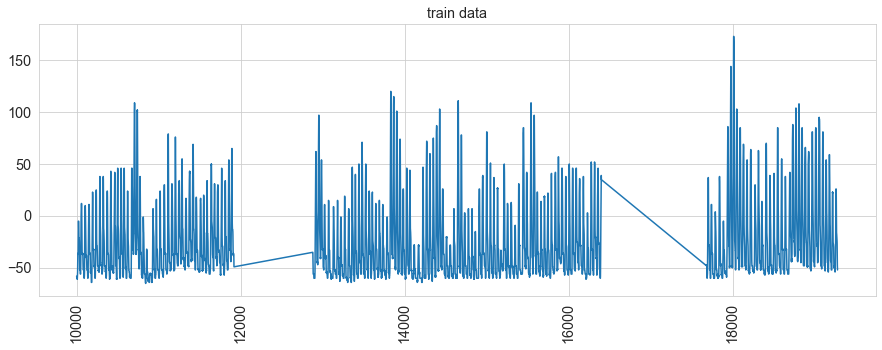

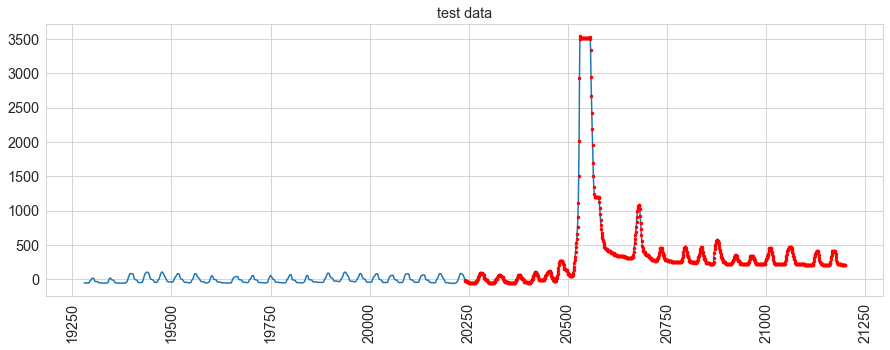

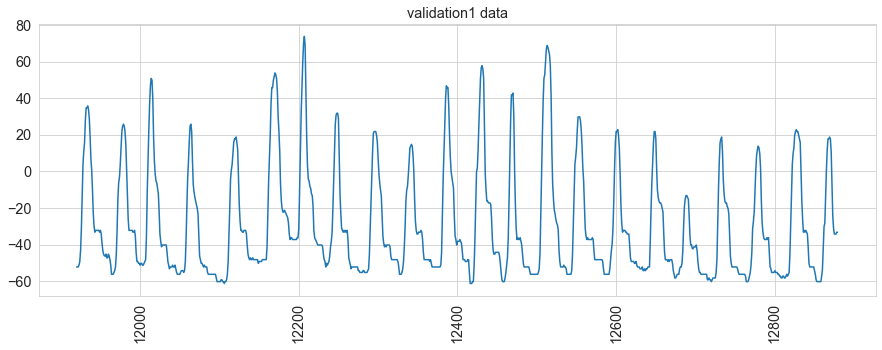

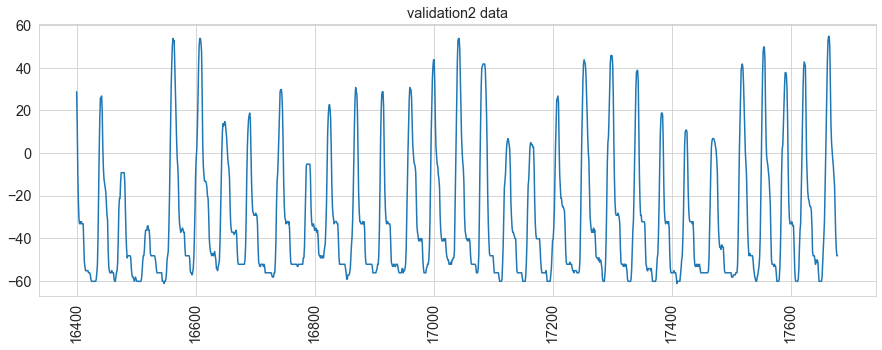

In [10]:
count = 0
for key in df_dict:
    print("Size of %s: %s"%(key,df_dict[key].shape))
    count += df_dict[key].shape[0]
print("Total: %d"%(count))

for key in df_dict:
    print("Ratio of %s: %f"%(key,float(df_dict[key].shape[0])/count))

for key in df_dict:
    plt.figure()
    df_tmp = df_dict[key]
    df_tmp['values'].plot(figsize=(15,5))
    rows = df_tmp[df_tmp.anomaly.isin([1])].itertuples()
    for row in rows:
        plt.plot(row[0], row[1], 'r.', markersize=5.0)
    plt.xticks(rotation='vertical')
    plt.title("%s data"%(key))
    plt.show()

In [12]:
for key in df_dict:
    np.save("../resources/data/discords/respiration/%s"%(key),df_dict[key])

### Part 2: Prediction Modeling
Use python scripts: *lstm_predictor.py , stateful_lstm_predictor.py*.

In [57]:
data_folder = "../resources/data/discords/respiration/"

In [58]:
import numpy as np
#load training data
train_predictions = np.load(data_folder+"train_predictions.npy")
train_true = np.load(data_folder+"train_true.npy")
print(train_predictions.shape)
print(train_true.shape)


(7012, 8)
(7012,)


In [59]:
#load validation2 data
validation2_predictions = np.load(data_folder+"validation2_predictions.npy")
validation2_true = np.load(data_folder+"validation2_true.npy")
validation2_labels = np.load(data_folder+"validation2_labels.npy")
print(np.shape(validation2_predictions))
print(np.shape(validation2_true))
print(np.shape(validation2_labels))
validation2_labels = np.reshape(validation2_labels,[len(validation2_labels),np.shape(validation2_labels)[1]])
print(np.shape(validation2_labels))


(1252, 8)
(1252,)
(1252, 8, 1)
(1252, 8)


In [60]:
# load test data
test_predictions = np.load(data_folder+"test_predictions.npy")
test_true = np.load(data_folder+"test_true.npy")
test_labels = np.load(data_folder+"test_labels.npy")
print(np.shape(test_predictions))
print(np.shape(test_true))
test_labels = np.reshape(test_labels,[len(test_labels),np.shape(test_labels)[1]])
print(np.shape(test_labels))

(1892, 8)
(1892,)
(1892, 8)


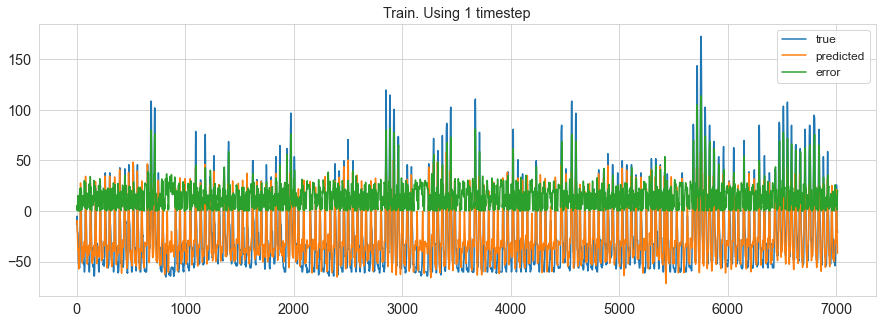

In [61]:
plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.legend()
plt.title("Train. Using 1 timestep")
plt.show()

[0.45977003 0.45531948 0.45128588 0.44761633 0.44456648 0.44256579
 0.44200133 0.44322146]
[[ 416.63142044  388.5933453   355.43295974  322.60411738  296.19102614
   280.26594645  276.10523482  283.10366182]
 [ 388.5933453   395.75909937  394.69437184  386.14623183  374.57759404
   365.0256656   360.90710726  363.80303005]
 [ 355.43295974  394.69437184  428.83285893  452.37937772  465.08968058
   470.38003876  472.63190785  475.56634585]
 [ 322.60411738  386.14623183  452.37937772  511.12730003  555.92974295
   585.4955745   602.58571858  611.88588813]
 [ 296.19102614  374.57759404  465.08968058  555.92974295  635.92985354
   697.58253904  738.94206245  763.07413815]
 [ 280.26594645  365.0256656   470.38003876  585.4955745   697.58253904
   794.42573977  867.86346148  916.25622714]
 [ 276.10523482  360.90710726  472.63190785  602.58571858  738.94206245
   867.86346148  976.48149902 1056.94111984]
 [ 283.10366182  363.80303005  475.56634585  611.88588813  763.07413815
   916.25622714 10

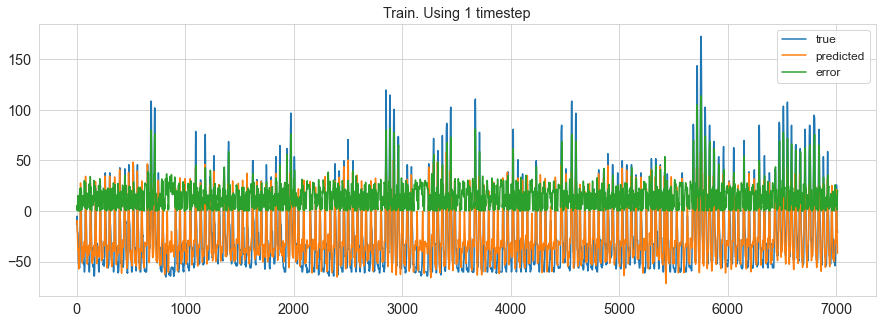

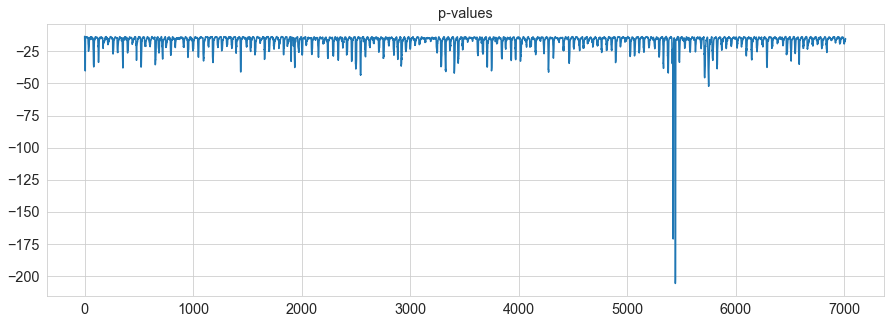

In [62]:
#error vectors
from scipy.stats import norm
from scipy.stats import multivariate_normal

train_error_vectors = np.zeros(np.shape(train_predictions))
n_cols = np.shape(train_predictions)[1]
for i in range(n_cols):
    train_error_vectors[:,i] =  train_true -train_predictions[:,i]

mean = np.mean(train_error_vectors, axis=0)
cov = np.cov(train_error_vectors,rowvar=False)
print(mean)
print(cov)
p_values= multivariate_normal.logpdf(train_error_vectors,mean,cov)

plt.figure(figsize=(15,5))
plt.plot(train_true,label='true')
plt.plot(train_predictions[:,0],label='predicted')
plt.plot(abs(train_true - train_predictions[:,0]),label='error')
plt.title("Train. Using 1 timestep")
plt.legend()

# plt.figure(figsize=(15,5))
# plt.plot(train_true,label='true')
# plt.plot(train_predictions[:,5],label='predicted')
# plt.plot(abs(train_true - train_predictions[:,5]),label='error')
# plt.title("Train. Using 6 timestep")
# plt.legend()

plt.figure(figsize=(15,5))
plt.plot(p_values)
plt.title("p-values")
plt.show()

train_errors_1 = train_true - train_predictions[:,0]

In [63]:
v2_error_vectors = np.zeros(np.shape(validation2_predictions))
for i in range(n_cols):
    v2_error_vectors[:,i] =  validation2_true -validation2_predictions[:,i]
v2_p_values= multivariate_normal.logpdf( v2_error_vectors,mean,cov)
# v2_true_anomalies = np.where(validation2_labels[:,0]==1)
# print "Validation2. Number True Anomalies: %d"%(np.shape(v2_true_anomalies)[1])
# print "Validation2. Location of anomalies: %s"%(v2_true_anomalies)
# print "validation2. True anomalies: %s"%(validation2_true[v2_true_anomalies])
# v2_thresholds =v2_p_values[v2_true_anomalies]
# print "validation2. p-values at true anomalies: %s"%(v2_thresholds)

# print 
test_error_vectors = np.zeros(np.shape(test_predictions))
for i in range(n_cols):
    test_error_vectors[:,i] =  test_true -test_predictions[:,i]
test_p_values= multivariate_normal.logpdf( test_error_vectors,mean,cov)
test_true_anomalies = np.where(test_labels[:,0]==1)
# print "Test. Number True Anomalies in: %d"%(np.shape(test_true_anomalies)[1])
# print "Test. Location of anomalies: %s"%(test_true_anomalies)
# print "Test. True anomalies: %s"%(test_true[test_true_anomalies])
# test_thresholds = test_p_values[test_true_anomalies]
# print "Test. p-values at true anomalies: %s"%(test_thresholds)




[2 3 4 5 6]


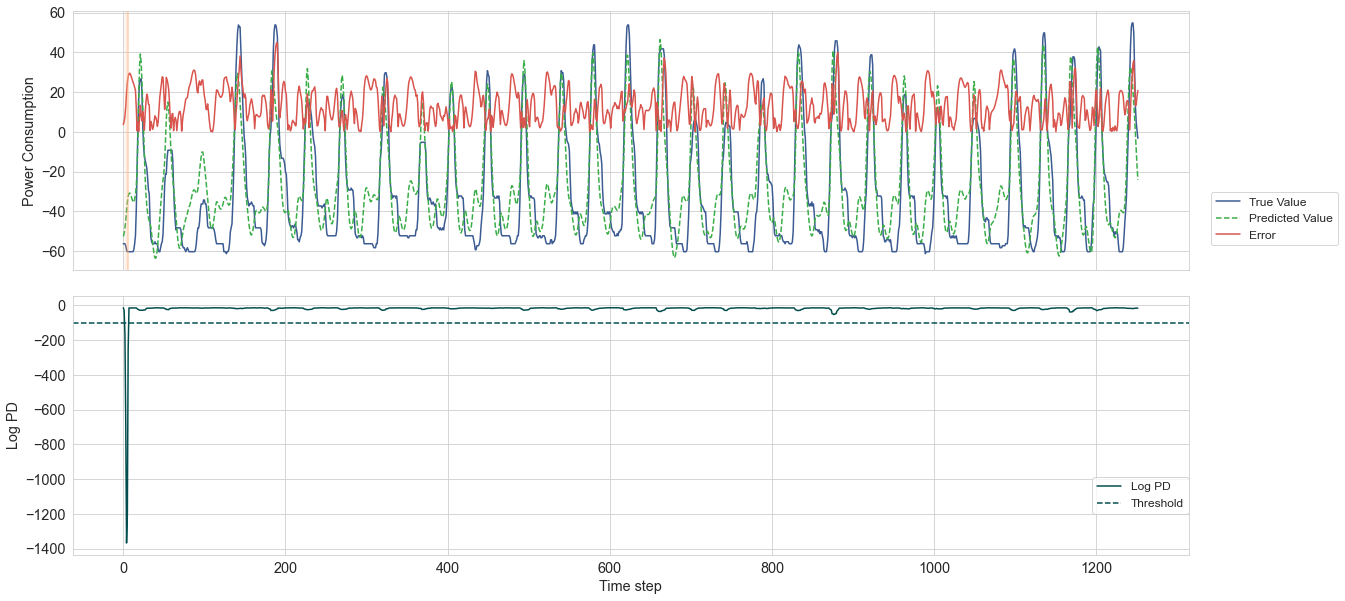

In [64]:
threshold_v2 = -100

f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)

v2_below_threshold = np.where(v2_p_values <= threshold_v2)
ax1 = plt.subplot(211)
ax1.plot(validation2_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(validation2_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
ax1.plot(abs(validation2_true - validation2_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in v2_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=.1)
print(v2_below_threshold[0])
ax1.axvline(x=v2_below_threshold[0][-1],color=sns.xkcd_rgb["peach"],alpha=.5)
#for row in v2_true_anomalies:
#    plt.plot(row, validation2_true[row], 'r.', markersize=20.0)
ax1.legend(bbox_to_anchor=(1.02,.3),borderaxespad=0.,frameon=True)
plt.ylabel("Power Consumption")
#plt.title("Validation2. Using 1 timestep")


#plot v2 log PD
ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(v2_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
ax2.legend(bbox_to_anchor=(1, .3), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#plt.title("Validation2 p-values")

#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()
pp = PdfPages('power_v2.pdf')
pp.savefig(f)
pp.close()

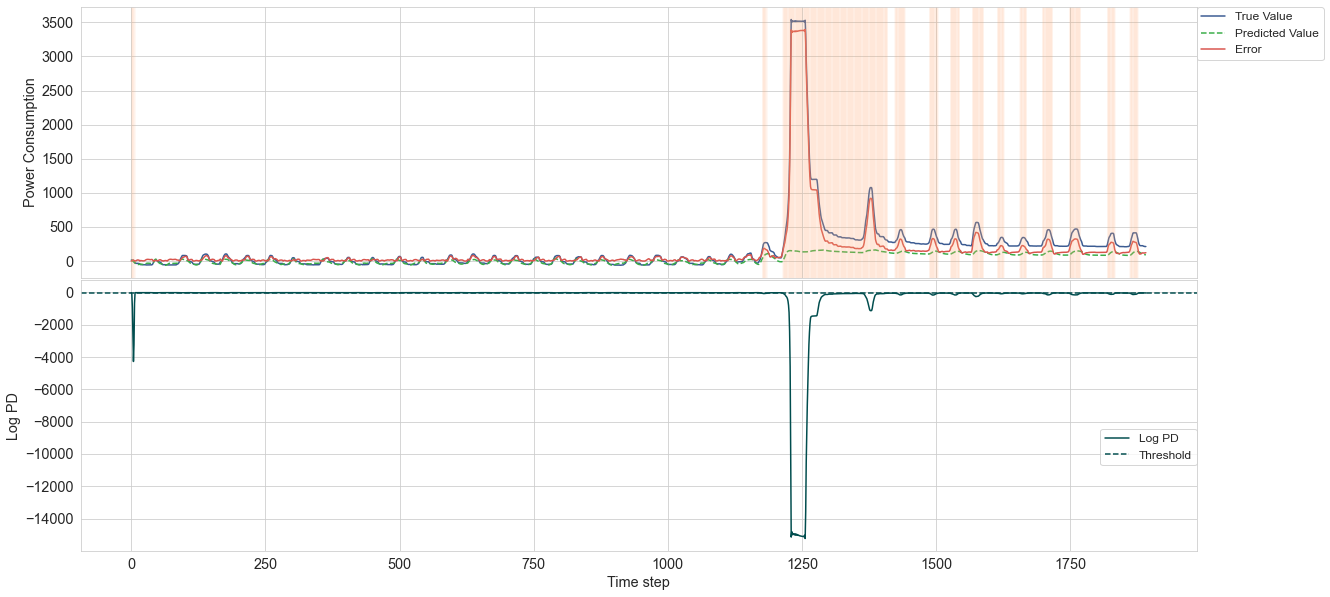

In [67]:
threshold_v2 = -50
test_below_threshold = np.where(test_p_values <= threshold_v2)
#plot test data
f = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.01)

ax1 = plt.subplot(211)
ax1.plot(test_true,label='True Value',color=sns.xkcd_rgb["denim blue"])
ax1.plot(test_predictions[:,0],ls ='dashed',label='Predicted Value',color=sns.xkcd_rgb["medium green"])
ax1.plot(abs(test_true - test_predictions[:,0]),label='Error',color=sns.xkcd_rgb["pale red"])
for column in test_below_threshold[0]:
    ax1.axvline(x=column,color=sns.xkcd_rgb["peach"],alpha=0.1)
#for row in test_true_anomalies:
#    plt.plot(row, test_true[row], 'r.', markersize=20.0)
ax1.legend(bbox_to_anchor=(1, 1), borderaxespad=0.,frameon=True)
plt.ylabel("Power Consumption")
#plt.title("Test. Using 1 timestep")

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(test_p_values,label='Log PD',color=sns.xkcd_rgb["dark teal"])
ax2.axhline(y=threshold_v2,ls='dashed',label='Threshold',color=sns.xkcd_rgb["dark teal"])
ax2.legend(bbox_to_anchor=(1, .45), borderaxespad=0.,frameon=True)
plt.ylabel("Log PD")
#plt.title("test p-values")

#Set up the xlabel and xtick
#xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step")
plt.show()
pp = PdfPages('power_test.pdf')
pp.savefig(f)
pp.close()